In [1]:
!pip install feature-engine

In [2]:
# import the required packages
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

import re
import seaborn as sns

import random
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn import tree

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import FunctionTransformer
from feature_engine.transformation import ReciprocalTransformer
from feature_engine.transformation import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

## 1. HR Analytics

### 1.1 Load and Explore the data

In [3]:
# Load dataset into a DataFrame
df = pd.read_csv('hr_data.csv')

# Create a copy of the DataFrame
df_hr = df.copy()

# Show overview of the dataset
df_hr.head()

employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                  8              1            0                  49   
1                  4              0            0                  60   
2                  7              0            0                  50   
3                 10              0            0                  50   
4                  2              0            0                  73   

   is_promoted  
0            0  
1            0  
2            0  
3            0  
4            0

In [4]:
df_hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [5]:
#categorical data
cat = [c for c in df_hr.columns if df_hr[c].dtypes=='O']
df_hr[cat].head()

department     region         education gender recruitment_channel
0  Sales & Marketing   region_7  Master's & above      f            sourcing
1         Operations  region_22        Bachelor's      m               other
2  Sales & Marketing  region_19        Bachelor's      m            sourcing
3  Sales & Marketing  region_23        Bachelor's      m               other
4         Technology  region_26        Bachelor's      m               other

In [6]:
#numerical data
numerical = [n for n in df_hr.columns if df_hr[n].dtypes!='O']
df_hr[numerical].head()

employee_id  no_of_trainings  age  previous_year_rating  length_of_service  \
0        65438                1   35                   5.0                  8   
1        65141                1   30                   5.0                  4   
2         7513                1   34                   3.0                  7   
3         2542                2   39                   1.0                 10   
4        48945                1   45                   3.0                  2   

   KPIs_met >80%  awards_won?  avg_training_score  is_promoted  
0              1            0                  49            0  
1              0            0                  60            0  
2              0            0                  50            0  
3              0            0                  50            0  
4              0            0                  73            0

In [7]:
df_hr.describe()

employee_id  no_of_trainings           age  previous_year_rating  \
count  54808.000000     54808.000000  54808.000000          50684.000000   
mean   39195.830627         1.253011     34.803915              3.329256   
std    22586.581449         0.609264      7.660169              1.259993   
min        1.000000         1.000000     20.000000              1.000000   
25%    19669.750000         1.000000     29.000000              3.000000   
50%    39225.500000         1.000000     33.000000              3.000000   
75%    58730.500000         1.000000     39.000000              4.000000   
max    78298.000000        10.000000     60.000000              5.000000   

       length_of_service  KPIs_met >80%   awards_won?  avg_training_score  \
count       54808.000000   54808.000000  54808.000000        54808.000000   
mean            5.865512       0.351974      0.023172           63.386750   
std             4.265094       0.477590      0.150450           13.371559   
min             1.000000       0.000000      0.000000           39.000000   
25%             3.000000       0.000000      0.000000           51.000000   
50%             5.000000       0.000000      0.000000           60.000000   
75%             7.000000       1.000000      0.000000           76.000000   
max            37.000000       1.000000      1.000000           99.000000   

        is_promoted  
count  54808.000000  
mean       0.085170  
std        0.279137  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [8]:
#cardinality
df_hr.nunique()

employee_id             54808
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
KPIs_met >80%               2
awards_won?                 2
avg_training_score         61
is_promoted                 2
dtype: int64

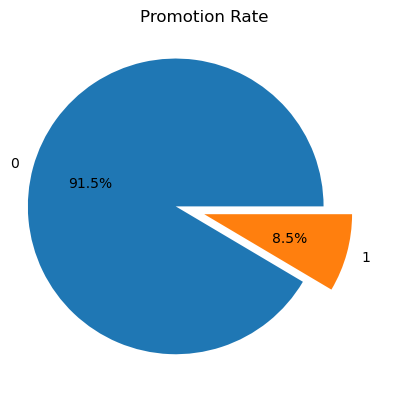

In [9]:
#chance of promotion
counts = df_hr['is_promoted'].value_counts()

# create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', explode = (0.2, 0))
plt.title('Promotion Rate')
plt.show()

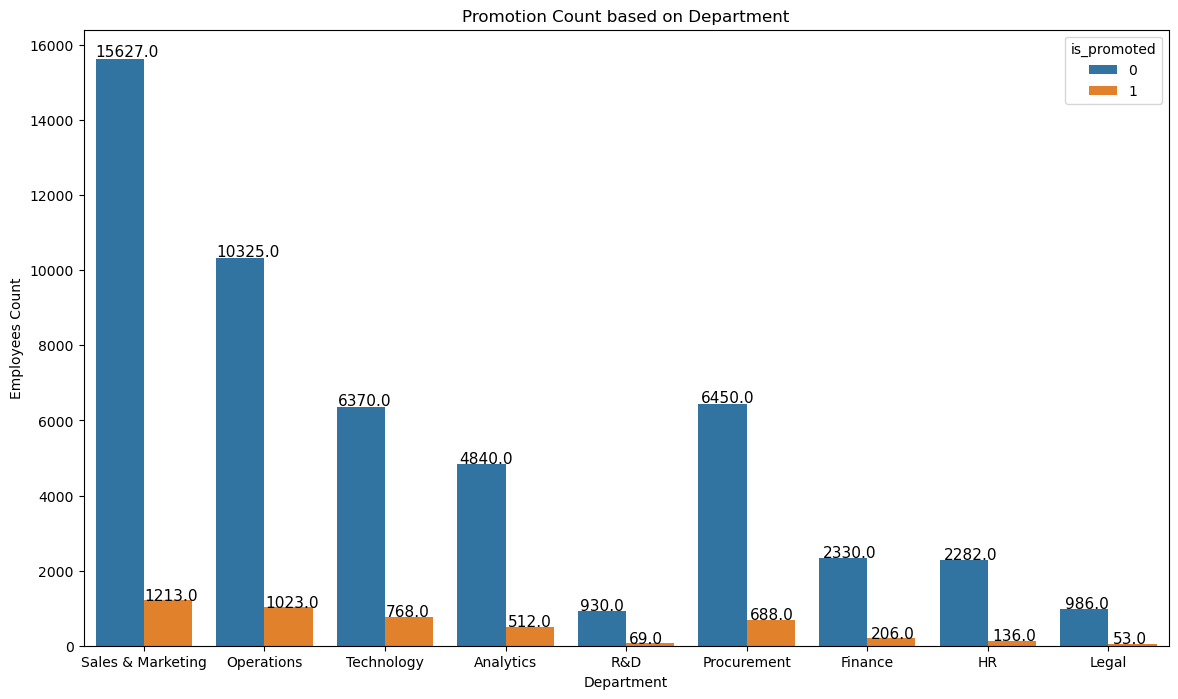

In [10]:
#promotion count based off department
plt.figure(figsize=(14,8))
ax = sns.countplot(x='department',hue='is_promoted',data=df_hr)

# add the data labels
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=11)

plt.title('Promotion Count based on Department')
plt.xlabel('Department')
plt.ylabel('Employees Count')
plt.show()


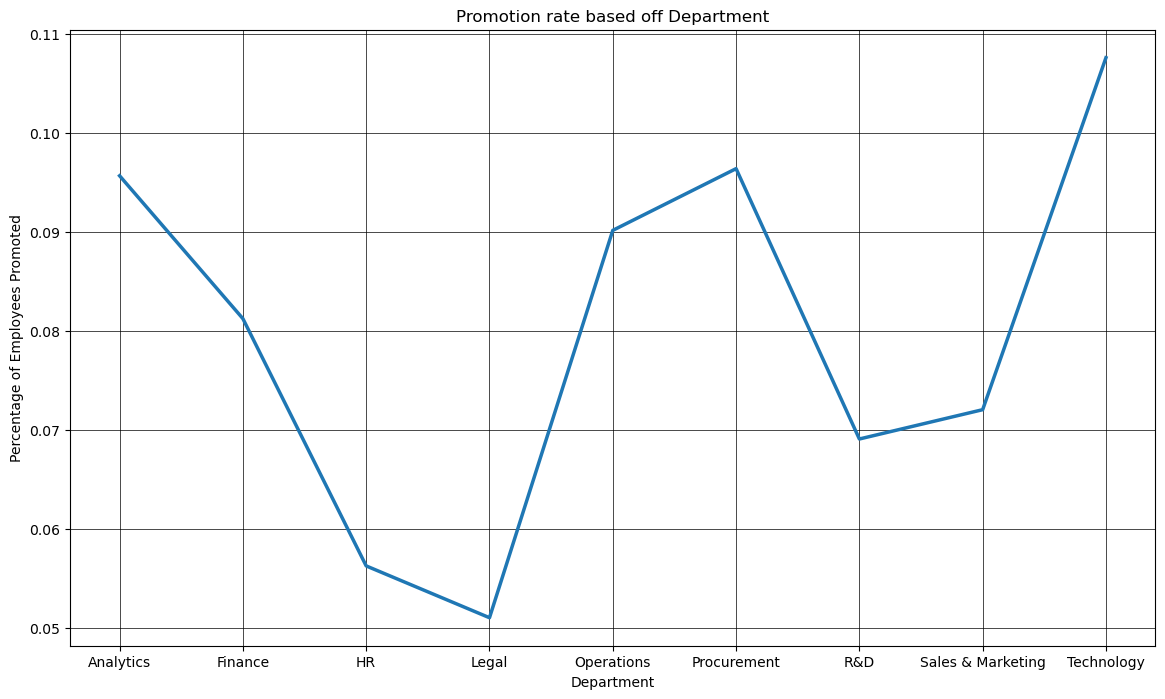

In [11]:
#Promotion rate based off department

# Group the data by department and "is_promoted" value
x = df_hr.groupby(['department', 'is_promoted'])['is_promoted'].count().unstack()

# Calculate the promotion rate for each department
x['%'] = x[1] / (x[0] + x[1])

# Create a figure and set the size
plt.figure(figsize=(14,8))

# Plot the promotion rates for each department
plt.plot(x['%'], linewidth=2.5)

# Add grid lines to the plot
plt.grid(color='black', linestyle='-', linewidth=0.5)

# Set the title and axis labels
plt.title('Promotion rate based off Department')
plt.xlabel('Department')
plt.ylabel('Percentage of Employees Promoted')

# Show the plot
plt.show()


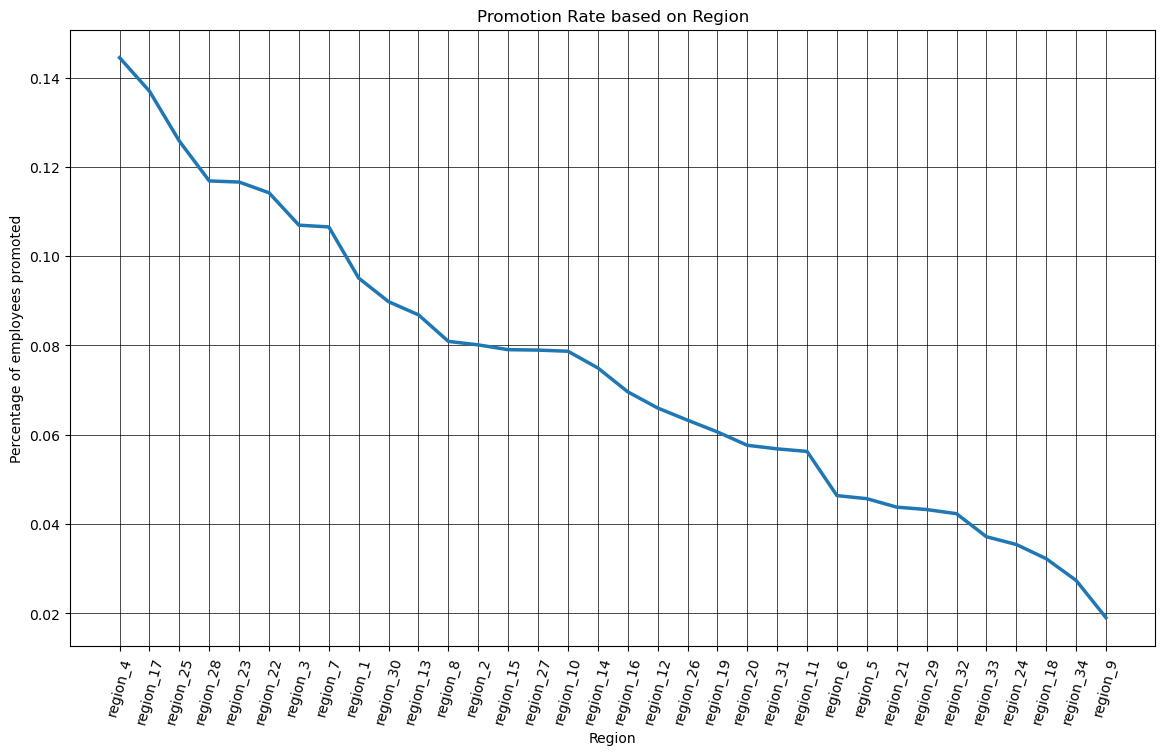

In [12]:
#Promotion rate based on Region
y=df_hr.groupby(['region','is_promoted'])['is_promoted'].count().unstack().fillna(0)
y['%']=y[1]/(y[0]+y[1])#calculation of promotion %
y=y.sort_values('%',ascending=False) #sorting by promotion rate to get insights easily
plt.figure(figsize=(14,8))
plt.plot(y['%'], linewidth=2.5)
plt.grid(color = 'black', linestyle = '-', linewidth = 0.5)
plt.title('Promotion Rate based on Region')
plt.xlabel('Region')
plt.xticks(rotation=75)
plt.ylabel('Percentage of employees promoted')
plt.show()

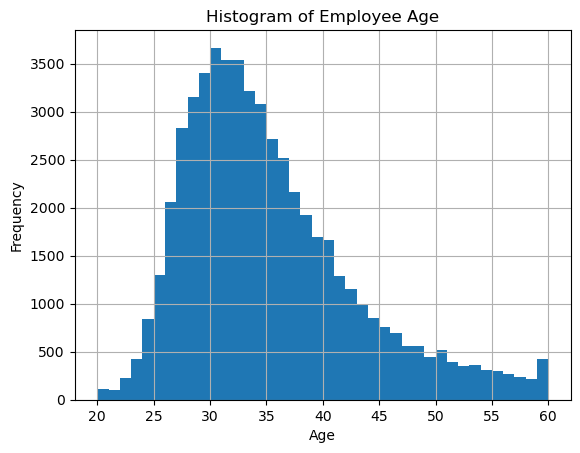

In [13]:
#Age distribution

plt.hist(df_hr['age'], bins=40)
plt.xlabel('Age')
plt.ylabel('Frequency') 
plt.title('Histogram of Employee Age')
plt.grid(True)

plt.show()

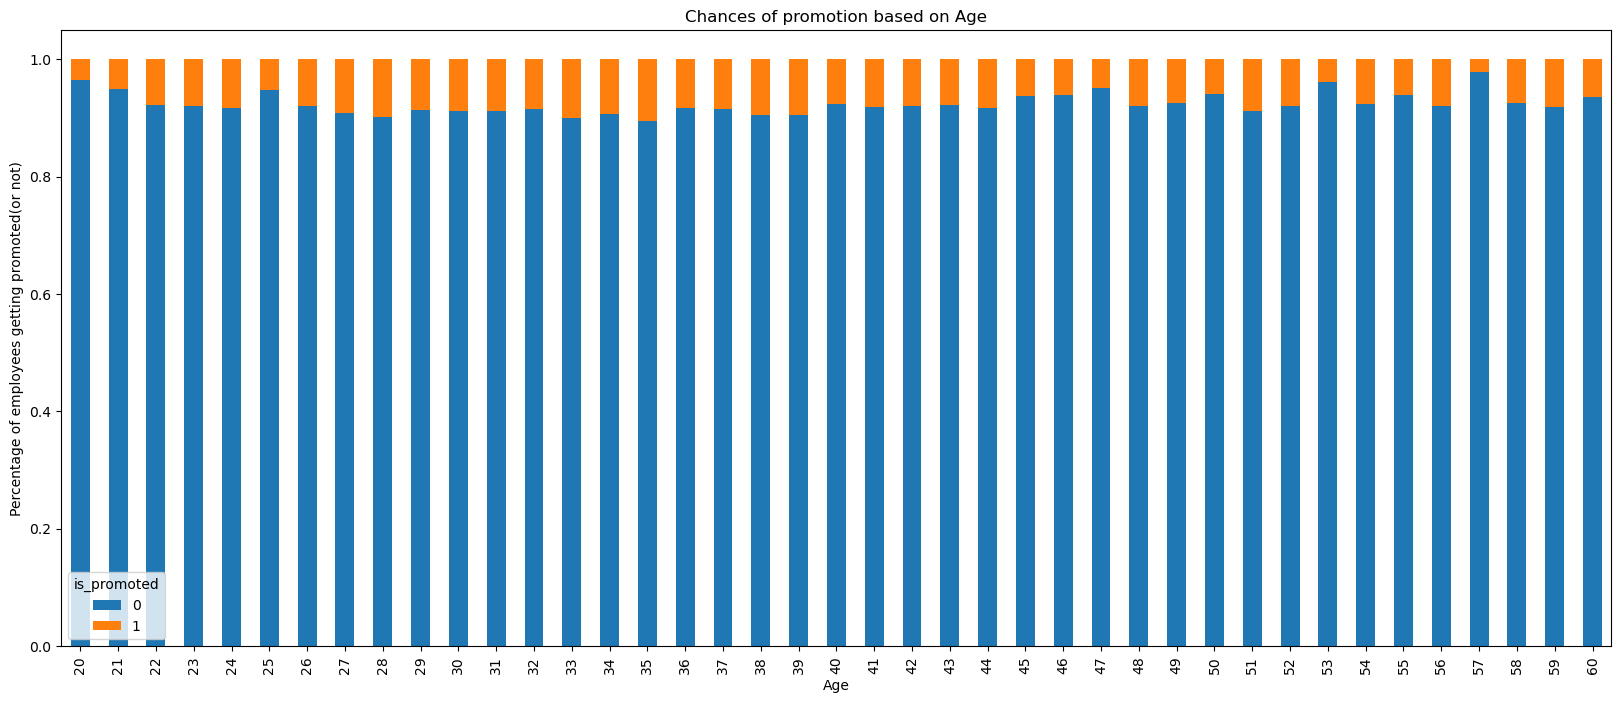

In [14]:
#Chances of promotion based off Age
y=df_hr.groupby(['age','is_promoted'])['is_promoted'].count().unstack().fillna(0)
y1=y.div(y.sum(1).astype('float'), axis = 0)
y1.plot(kind = 'bar', stacked = True, figsize = (20, 8))
plt.xlabel('Age')
plt.ylabel('Percentage of employees getting promoted(or not)')
plt.title("Chances of promotion based on Age")

plt.show()

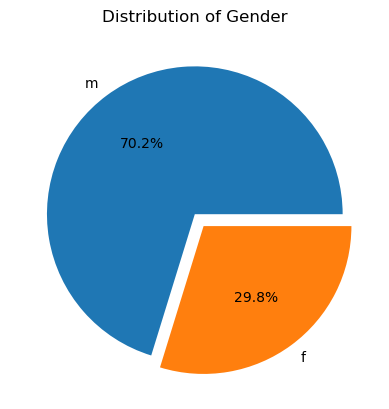

In [15]:
#Distribution of Gender
counts = df_hr['gender'].value_counts()

# create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', explode = (0, 0.1))
plt.title('Distribution of Gender')
plt.show()

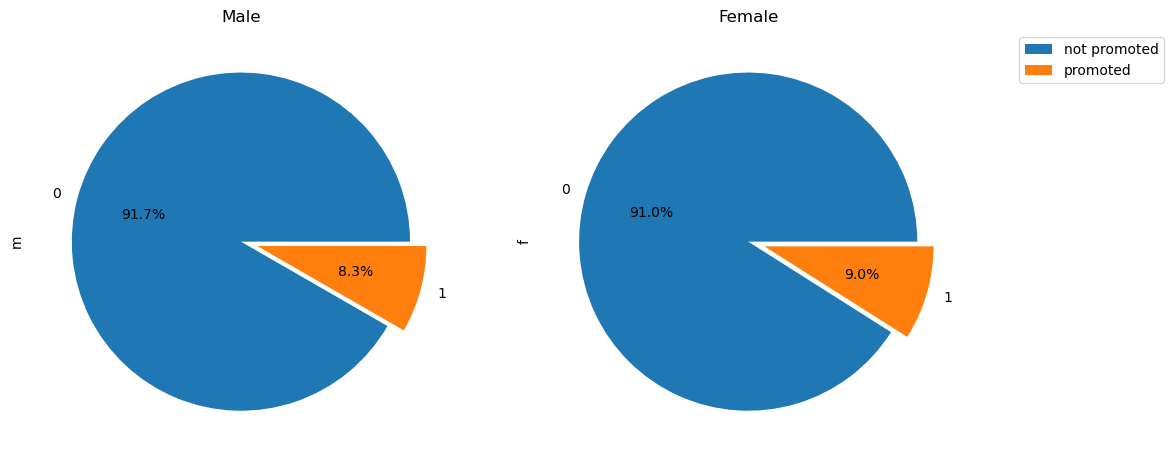

In [16]:
#Chances of Promotion based off Gender
y=df_hr.groupby(['gender','is_promoted'])['is_promoted'].count().unstack()
y=y.div(y.sum(1).astype('float'), axis = 0)

# create a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

# create the first pie chart
ax[0].set_title("Male")
df1 = y.loc['m']
df1.plot.pie(
    y="is_promoted",
    autopct="%1.1f%%",
    ax=ax[0],
    legend=False,
    explode = (0, 0.1)
)

# create the second pie chart
ax[1].set_title("Female")
df2 = y.loc['f']
df2.plot.pie(
    y="is_promoted",
    autopct="%1.1f%%",
    ax=ax[1],
    legend=False,
    explode = (0, 0.1)
)

# add a legend
plt.legend(['not promoted','promoted'],loc='upper right', bbox_to_anchor=(1, 0.5, 0.5, 0.5))

# show the figure
plt.show()

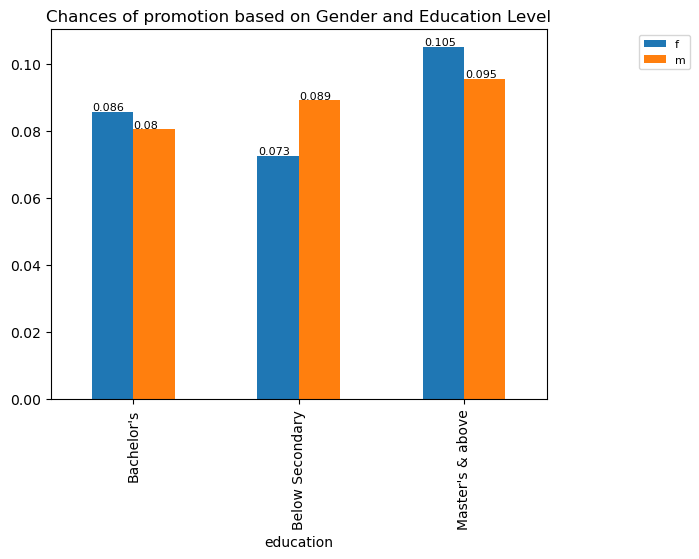

In [17]:
#Chances of promotion based on Gender and Education Level
# create the plot
ax = df_hr.groupby(['gender','education']).is_promoted.mean().unstack(0).plot.bar()

# add the data labels
for p in ax.patches:
    ax.annotate(round(p.get_height(), 3), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=8)

plt.title("Chances of promotion based on Gender and Education Level")
plt.legend(loc="upper right", fontsize=8, bbox_to_anchor=(1.3, 1))
plt.show()

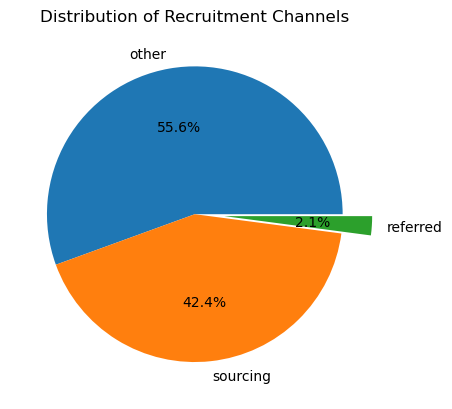

In [18]:
#Recruitment Channel Distribution
# calculate the counts for each value
counts = df_hr['recruitment_channel'].value_counts()

# create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', explode = (0, 0, 0.2))
plt.title('Distribution of Recruitment Channels')
plt.show()

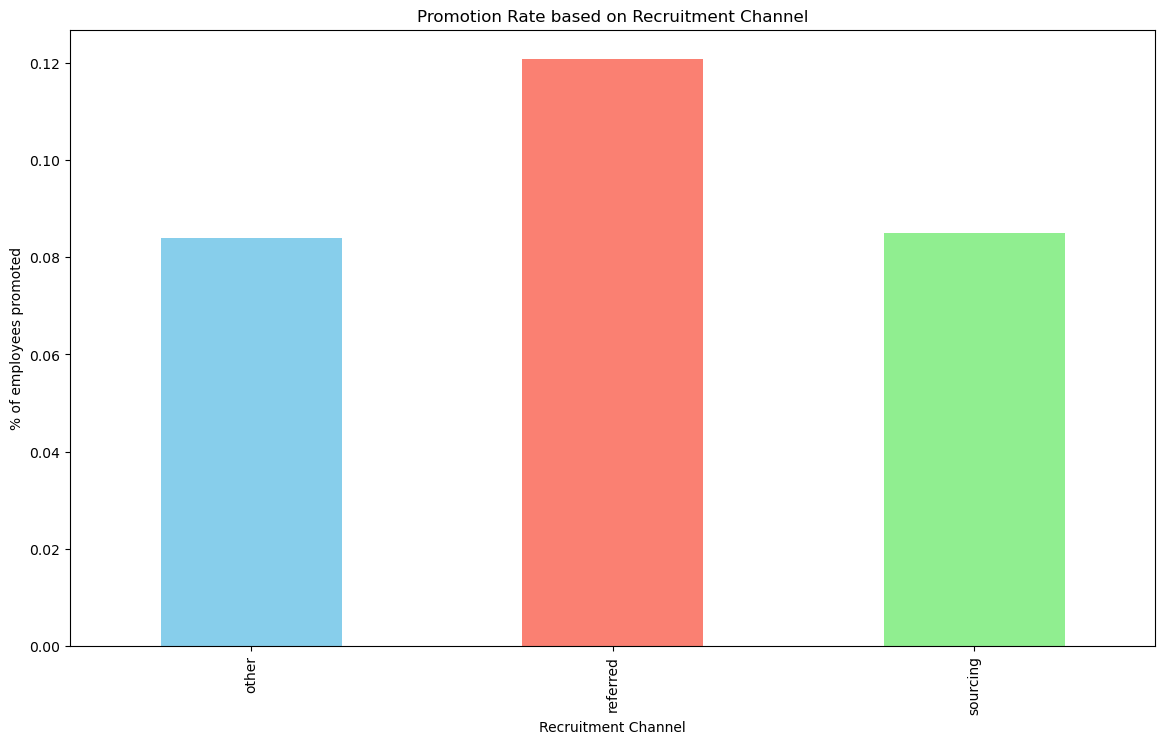

In [19]:
# Assuming df_hr is your DataFrame
plt.figure(figsize=(14, 8))

# Group by 'recruitment_channel' and 'is_promoted', calculate counts and promotion %
z = df_hr.groupby(['recruitment_channel', 'is_promoted'])['is_promoted'].count().unstack().fillna(0)
z['%'] = z[1] / (z[0] + z[1])

# Define colors for the bars
bar_colors = ['skyblue', 'salmon', 'lightgreen']

# Plot the bar chart with specified colors
z['%'].plot.bar(color=bar_colors)

plt.title('Promotion Rate based on Recruitment Channel')
plt.xlabel('Recruitment Channel')
plt.ylabel('% of employees promoted')
plt.show()

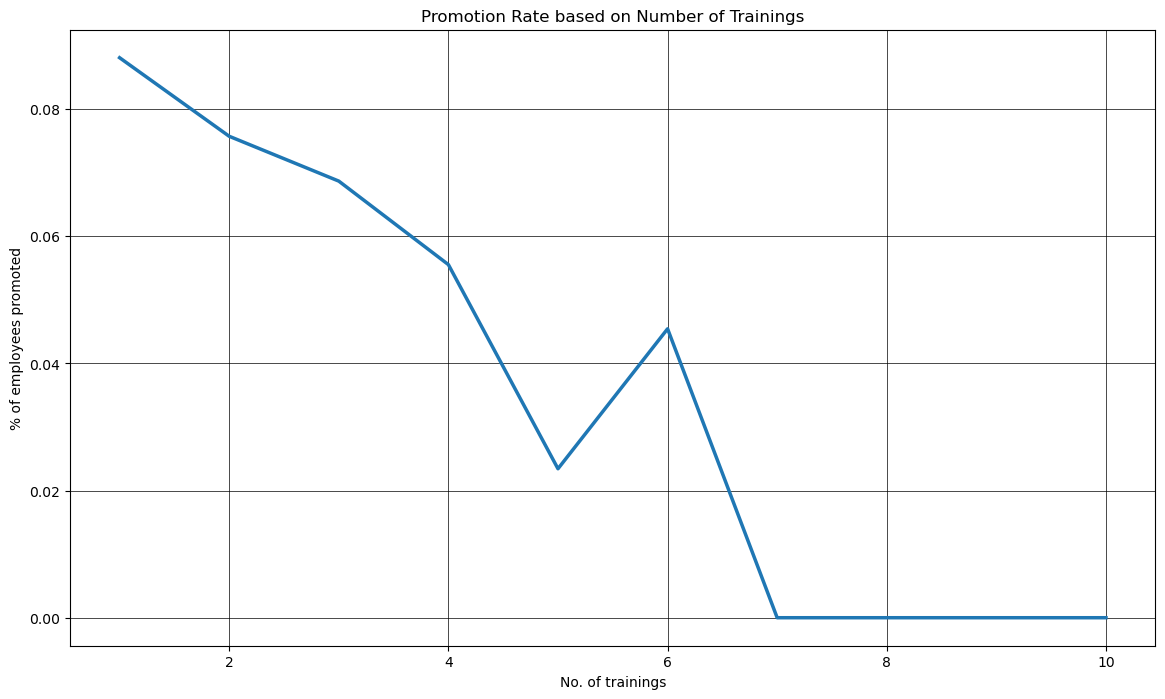

In [20]:
#Promotion Rate based on Number of Trainings
x=df_hr.groupby(['no_of_trainings'])['is_promoted'].value_counts().unstack().fillna(0)
x['%']=x[1]/(x[0] + x[1])#calculation of promotion %
plt.figure(figsize=(14,8))
plt.plot(x['%'], linewidth=2.5)
plt.grid(color = 'black', linestyle = '-', linewidth = 0.5)
plt.title('Promotion Rate based on Number of Trainings')
plt.xlabel('No. of trainings')
plt.ylabel('% of employees promoted')
plt.show()

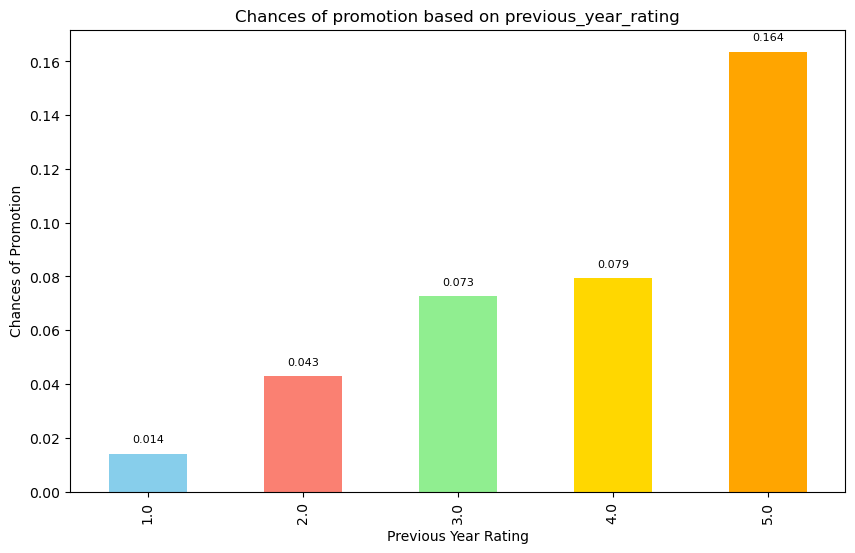

In [21]:
#Chances of promotion based on Previous Year Rating
#Create the plot
plt.figure(figsize=(10, 6))

# Group by 'previous_year_rating' and calculate mean of 'is_promoted'
ax = df_hr.groupby('previous_year_rating')['is_promoted'].mean().plot.bar(color=['skyblue', 'salmon', 'lightgreen', 'gold', 'orange'])

# Add the data labels
for p in ax.patches:
    ax.annotate(round(p.get_height(), 3), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.title("Chances of promotion based on previous_year_rating")
plt.xlabel("Previous Year Rating")
plt.ylabel("Chances of Promotion")
plt.show()

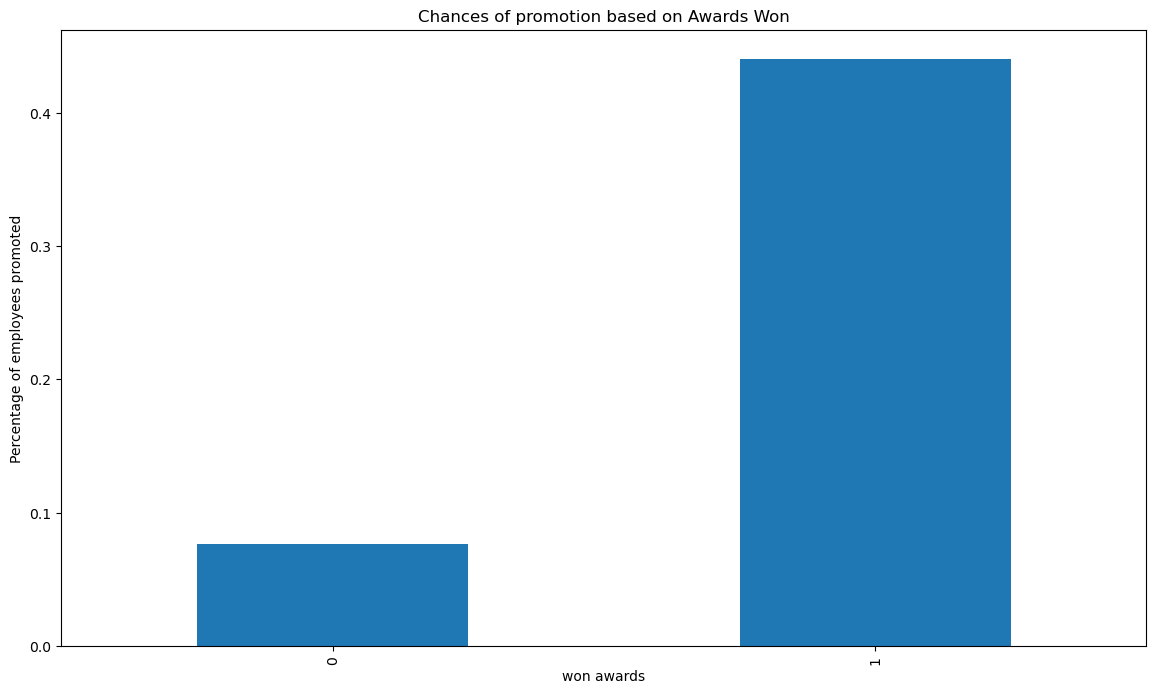

In [22]:
#Chances of promotion based on Awards Won
z=df_hr.groupby(['awards_won?','is_promoted'])['is_promoted'].count().unstack().fillna(0)
z['%']=z[1]/(z[0] + z[1])#calculation of promotion %
plt.figure(figsize=(14,8))
z['%'].plot.bar()
plt.title('Chances of promotion based on Awards Won')
plt.xlabel('won awards')
plt.ylabel('Percentage of employees promoted')
plt.show()

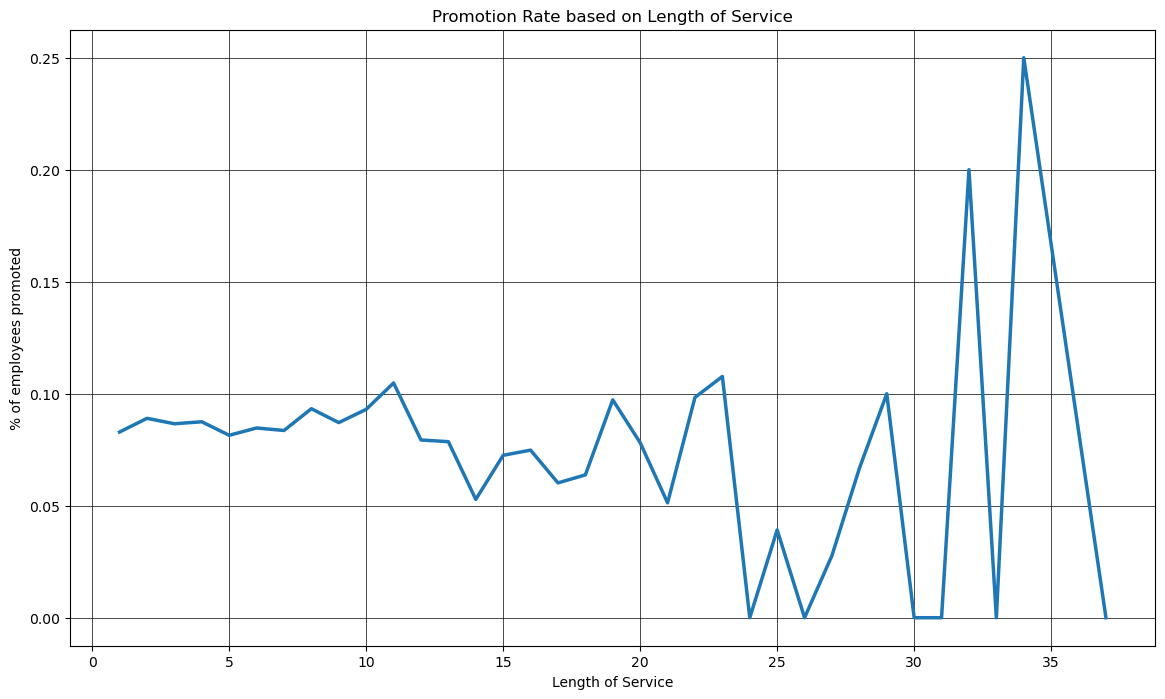

In [23]:
#Chances of promotion based on Length of Service
x=df_hr.groupby(['length_of_service'])['is_promoted'].value_counts().unstack().fillna(0)
x['%']=x[1]/(x[0] + x[1])#calculation of promotion %
plt.figure(figsize=(14,8))
plt.plot(x['%'], linewidth=2.5)
plt.grid(color = 'black', linestyle = '-', linewidth = 0.5)
plt.title('Promotion Rate based on Length of Service')
plt.xlabel('Length of Service')
plt.ylabel('% of employees promoted')
plt.show()

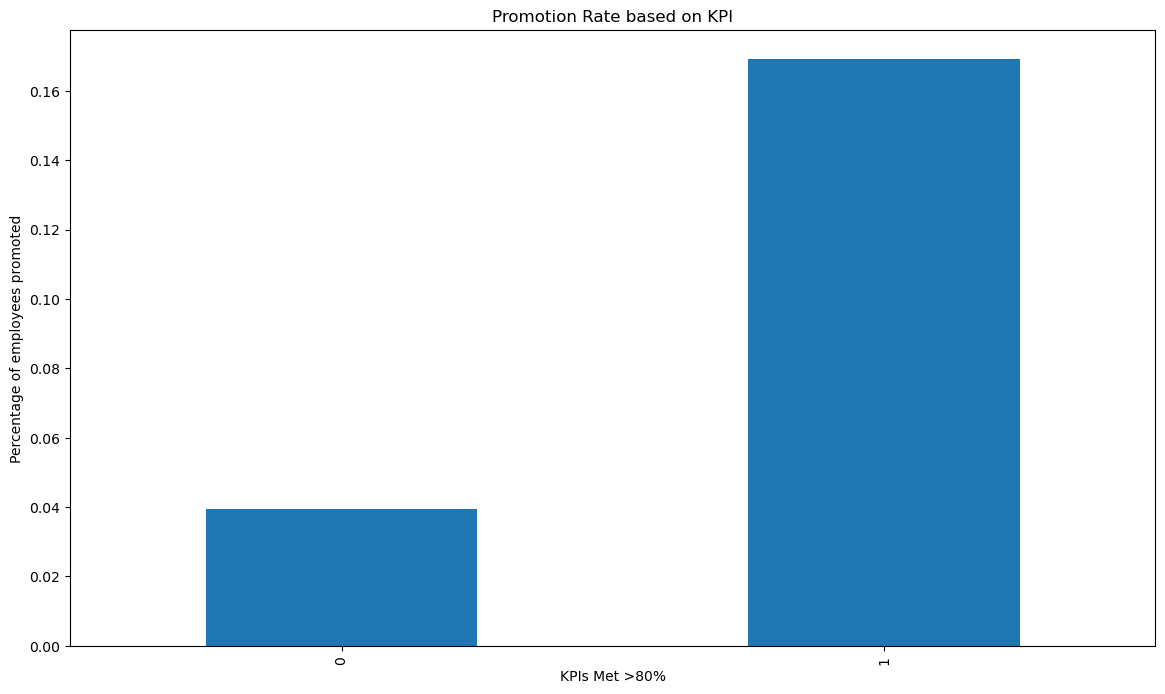

In [24]:
#Chances of promotion based on KPI
z=df_hr.groupby(['KPIs_met >80%','is_promoted'])['is_promoted'].count().unstack().fillna(0)
z['%']=z[1]/(z[0] + z[1])#calculation of promotion percentage
plt.figure(figsize=(14,8))
z['%'].plot.bar()
plt.title('Promotion Rate based on KPI')
plt.xlabel('KPIs Met >80%')
plt.ylabel('Percentage of employees promoted')
plt.show()

### 1.2 Cleanse and Transform the data

In [25]:
df_hr.columns = ['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'met_KPIs', 'won_awards',
       'avg_training_score', 'is_promoted']

# Update numerical column list
HR_num = [n for n in df_hr.columns if df_hr[n].dtypes!='O']
df_hr[HR_num].head()

employee_id  no_of_trainings  age  previous_year_rating  length_of_service  \
0        65438                1   35                   5.0                  8   
1        65141                1   30                   5.0                  4   
2         7513                1   34                   3.0                  7   
3         2542                2   39                   1.0                 10   
4        48945                1   45                   3.0                  2   

   met_KPIs  won_awards  avg_training_score  is_promoted  
0         1           0                  49            0  
1         0           0                  60            0  
2         0           0                  50            0  
3         0           0                  50            0  
4         0           0                  73            0

In [26]:
#Show missing Value Columns
df_hr.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
met_KPIs                   0
won_awards                 0
avg_training_score         0
is_promoted                0
dtype: int64

In [27]:
#Missing values for Education Column
df_hr['education'].value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

In [28]:
df_hr['education'].fillna('unknown',inplace=True)

# Check if values are changed
df_hr['education'].isnull().sum()

0

In [29]:
df_hr[df_hr.previous_year_rating.isnull()]['length_of_service'].describe()

count    4124.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: length_of_service, dtype: float64

In [30]:
df_hr['previous_year_rating'].fillna(0,inplace=True)

# Check if values are changed
df_hr['previous_year_rating'].isnull().sum()

0

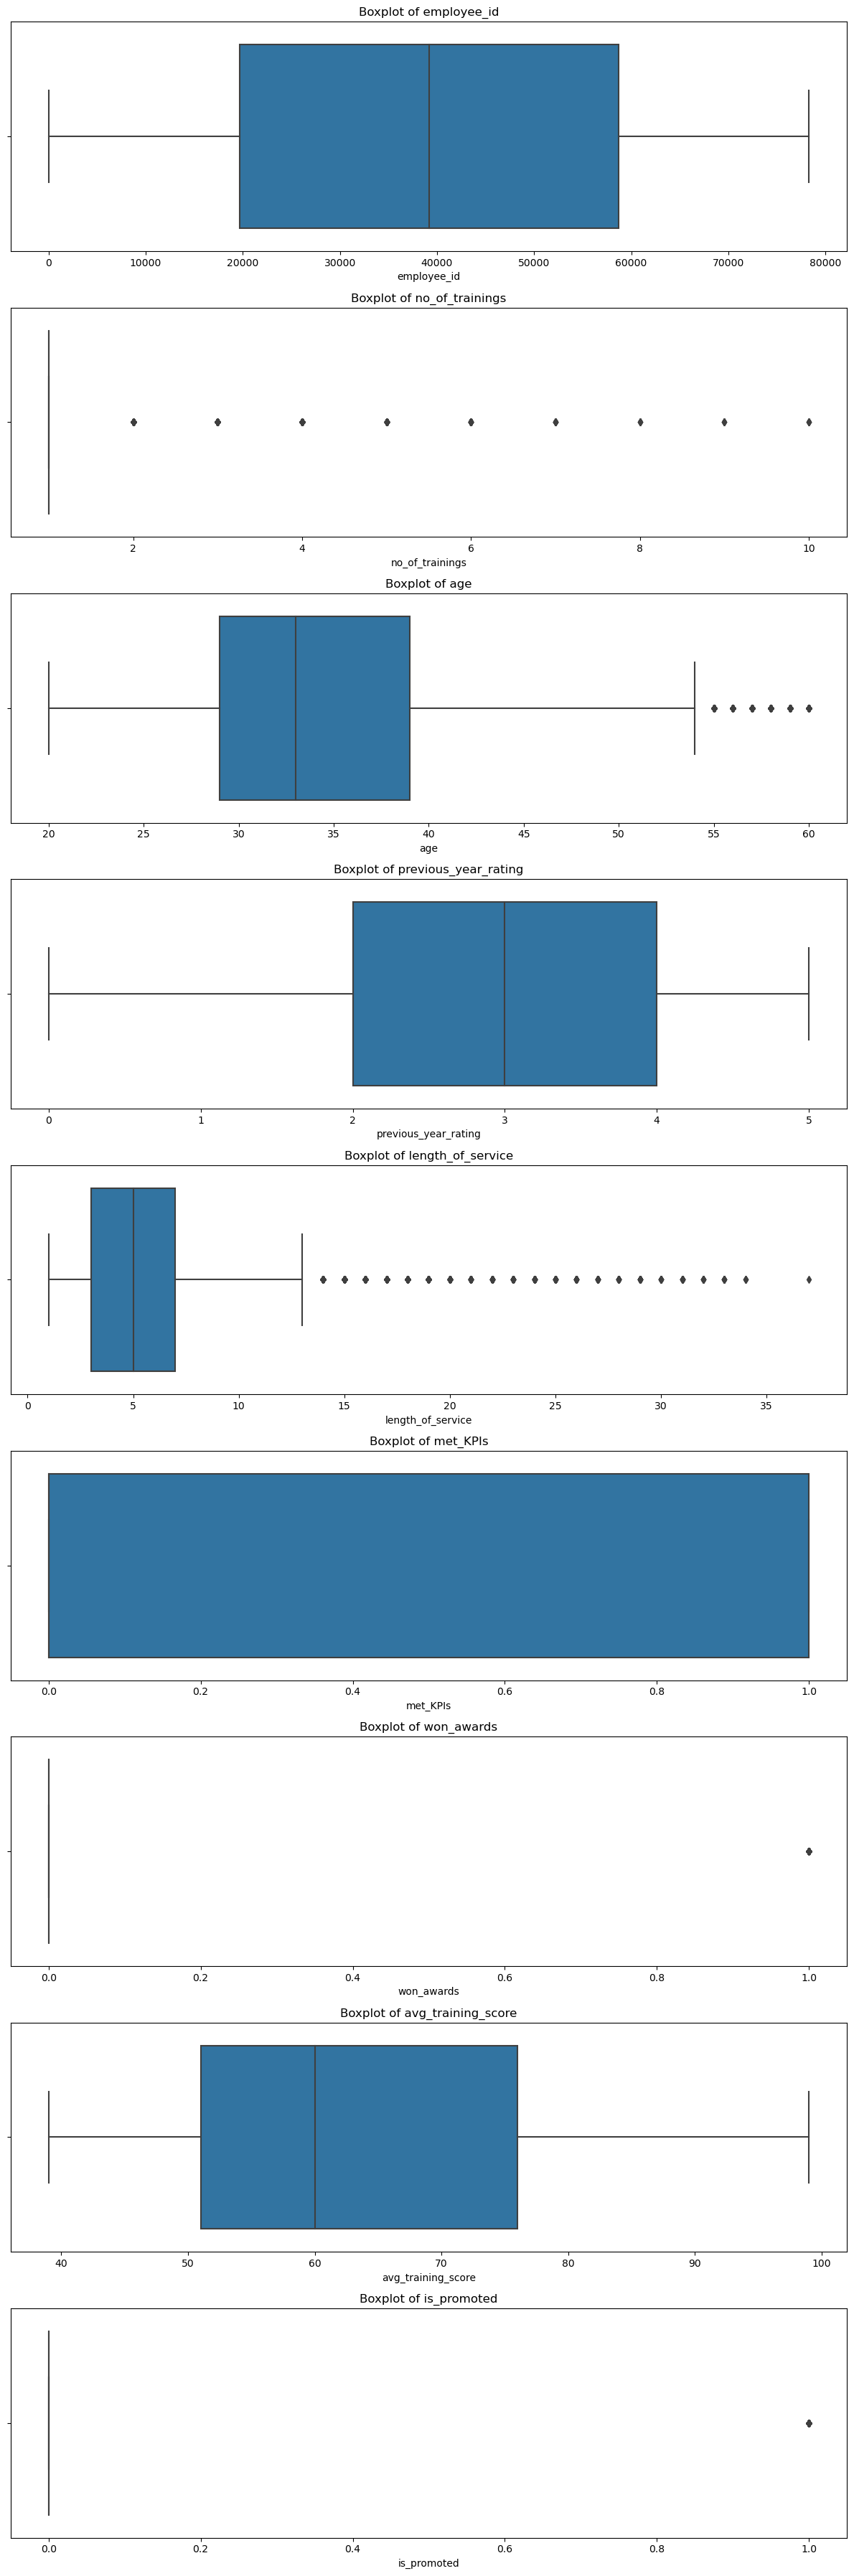

In [31]:
# Check for Outliers

# Create subplots
fig, axes = plt.subplots(nrows=len(HR_num), figsize=(12, len(HR_num) * 4))

# Loop through numerical columns and create boxplots
for i, column in enumerate(HR_num):
    sns.boxplot(x=df_hr[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [32]:
#Performing Numerical Transformation

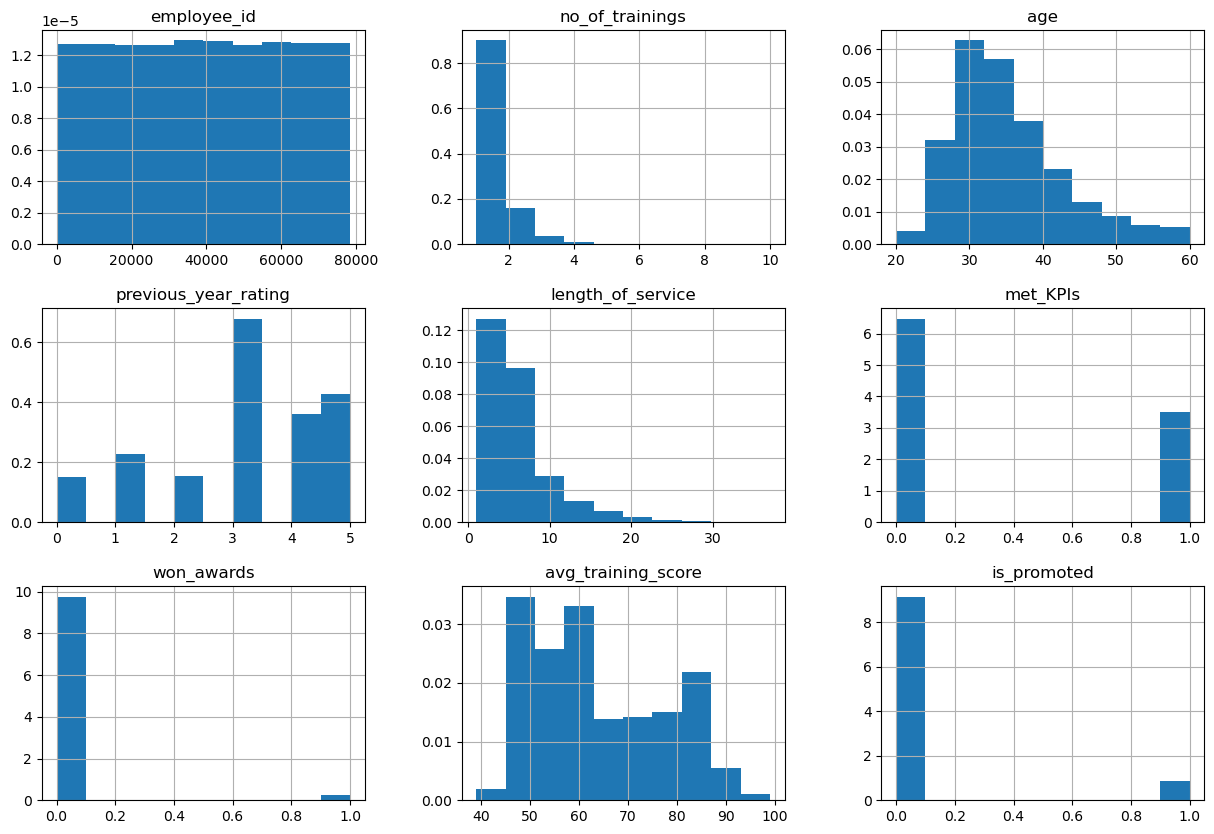

In [33]:
df_hr.hist(figsize=(15,10), density=True)
plt.show()

In [34]:
#Beginning Numerical Transformation

df_hr_copy = df_hr.copy(deep=True)
variables_toTransform = ['age', 'length_of_service', 'avg_training_score']
df_hr_copy.head()

# function to plot histogram and Q-Q plots to have a look at the variable distribution
import scipy.stats as stats

def diagnostic_plots_NUM(df, variable):
    
    # exclude infinite values from the data
    df = df[np.isfinite(df[variable])]
    
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)


    plt.show()

In [35]:
#Applying the Transformation
# Square root transformation
for column in variables_toTransform:
    df_hr_copy[column+'_square']=df_hr_copy[column]**(1/2)

# cube root transformation
for column in variables_toTransform:
    df_hr_copy[column+'_cube']=df_hr_copy[column]**(1/3)
    
# Log Transformation
for column in variables_toTransform:
    df_hr_copy[column+'_log'] = np.log(df_hr_copy[column])

# Reciprocal transformation
for column in variables_toTransform:
    df_hr_copy[column+'_rec']=1/(df_hr_copy[column])

In [36]:
def compare_transf(df,feature):
    compare=df[[feature+'_square', feature+'_cube', feature+'_rec', feature+'_log']].copy()
    for column in compare:
        print(column)
        diagnostic_plots_NUM(compare, column)

In [37]:
df_hr_copy.head()

employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  ...  avg_training_score_square  age_cube  \
0                  8  ...                   7.000000  3.271066   
1                  4  ...                   7.745967  3.107233   
2                  7  ...                   7.071068  3.239612   
3                 10  ...                   7.071068  3.391211   
4                  2  ...                   8.544004  3.556893   

   length_of_service_cube  avg_training_score_cube   age_log  \
0                2.000000                 3.659306  3.555348   
1                1.587401                 3.914868  3.401197   
2                1.912931                 3.684031  3.526361   
3                2.154435                 3.684031  3.663562   
4                1.259921                 4.179339  3.806662   

   length_of_service_log  avg_training_score_log   age_rec  \
0               2.079442                3.891820  0.028571   
1               1.386294                4.094345  0.033333   
2               1.945910                3.912023  0.029412   
3               2.302585                3.912023  0.025641   
4               0.693147                4.290459  0.022222   

   length_of_service_rec  avg_training_score_rec  
0               0.125000                0.020408  
1               0.250000                0.016667  
2               0.142857                0.020000  
3               0.100000                0.020000  
4               0.500000                0.013699  

[5 rows x 26 columns]

In [38]:
#Numerical Transformation for age

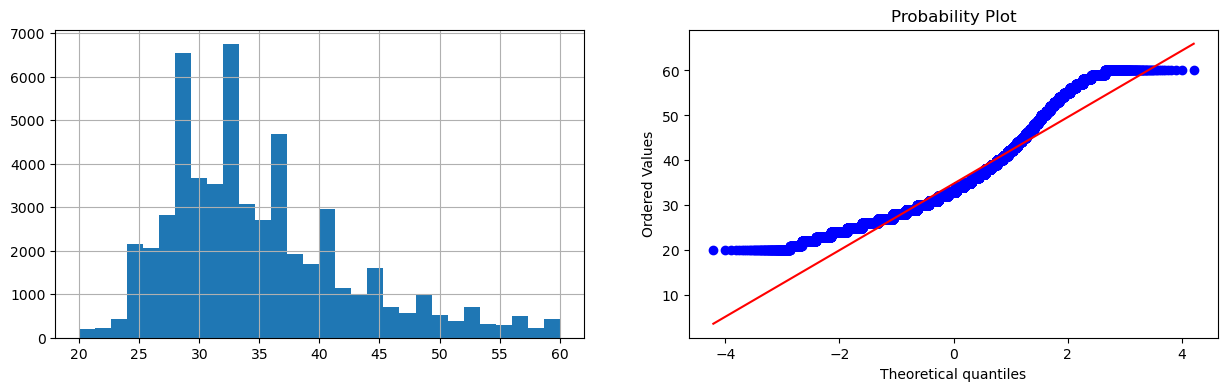

In [39]:
# Original Distribution 
diagnostic_plots_NUM(df_hr_copy, 'age')

age_square


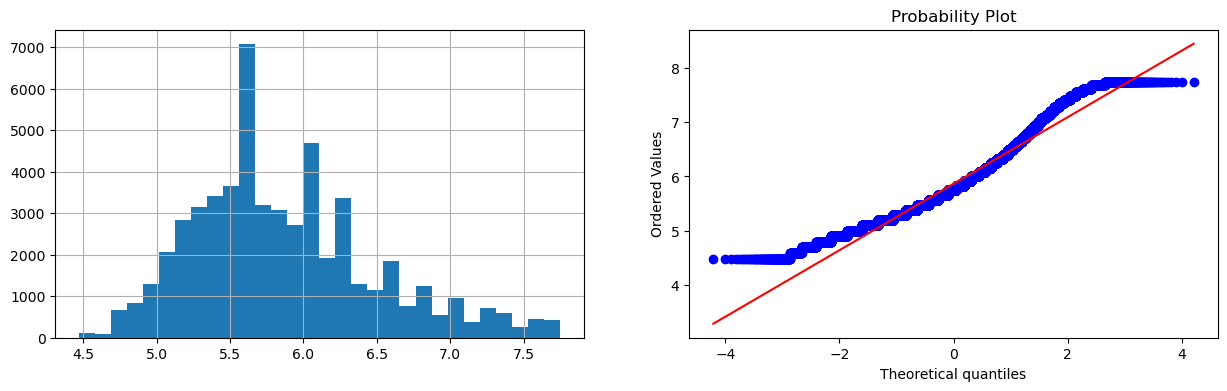

age_cube


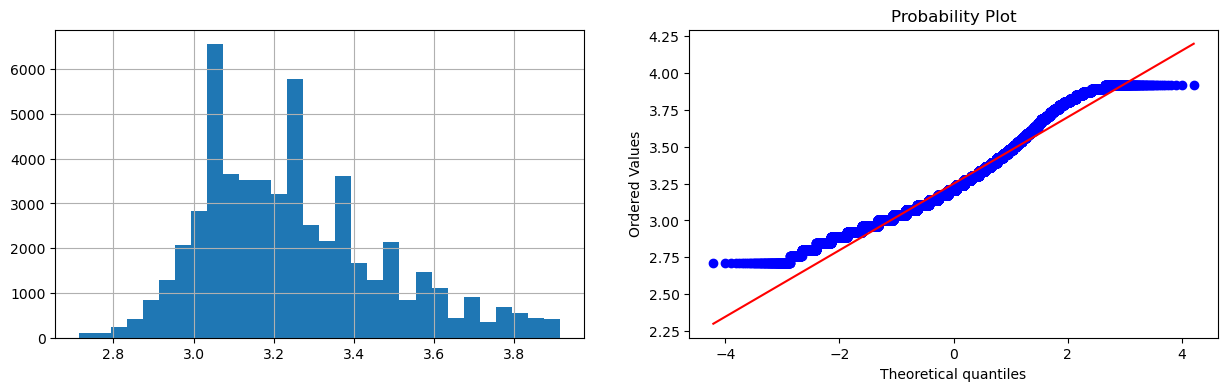

age_rec


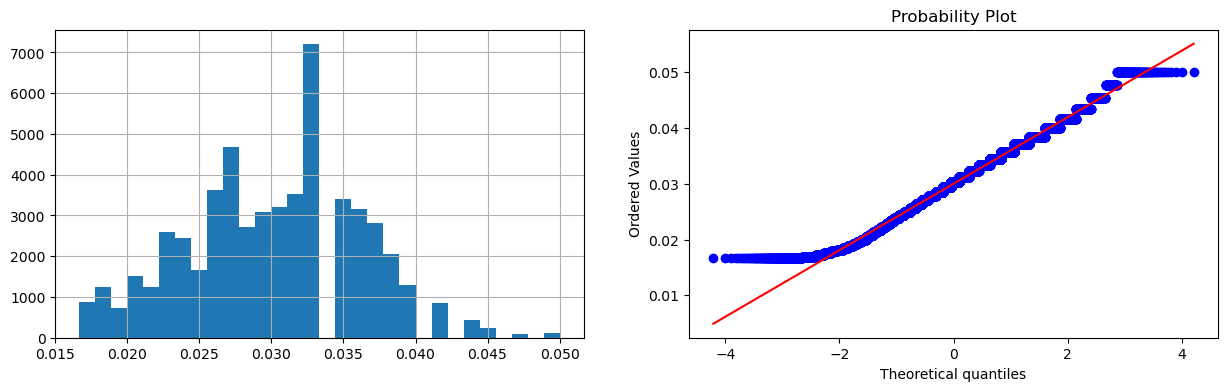

age_log


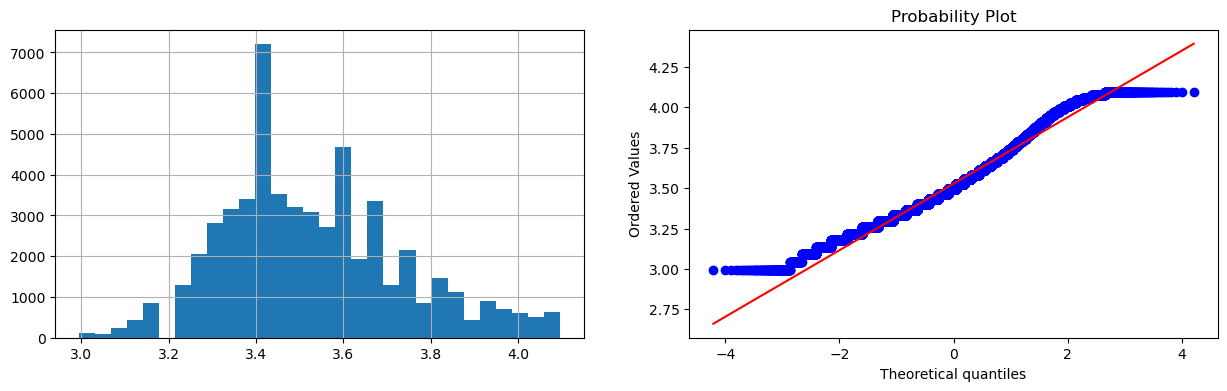

In [40]:
#different transformations
compare_transf(df_hr_copy, 'age')

In [41]:
#Numerical Transformation for length_of_service

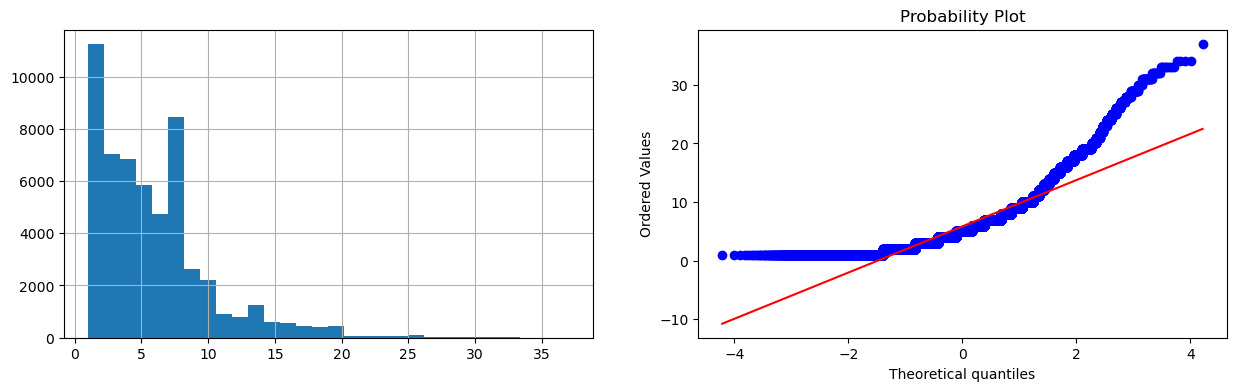

In [42]:
# Original Distribution 
diagnostic_plots_NUM(df_hr_copy, 'length_of_service')

length_of_service_square


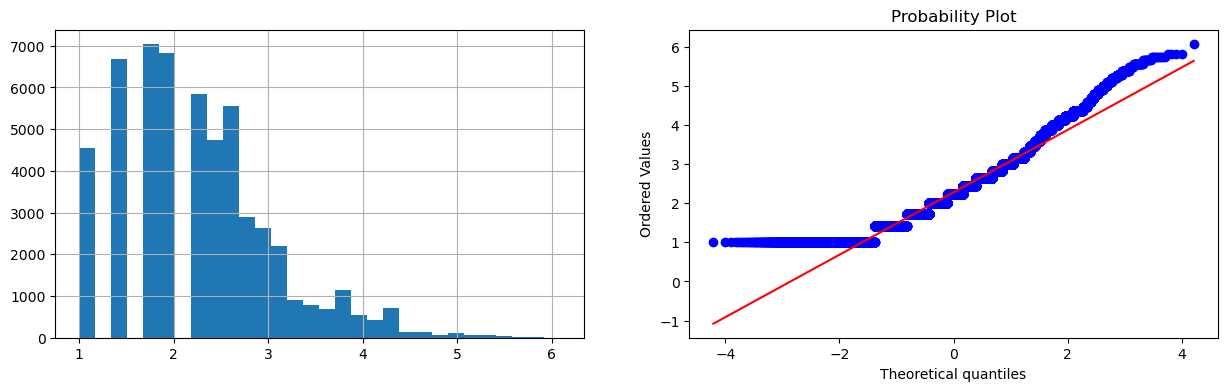

length_of_service_cube


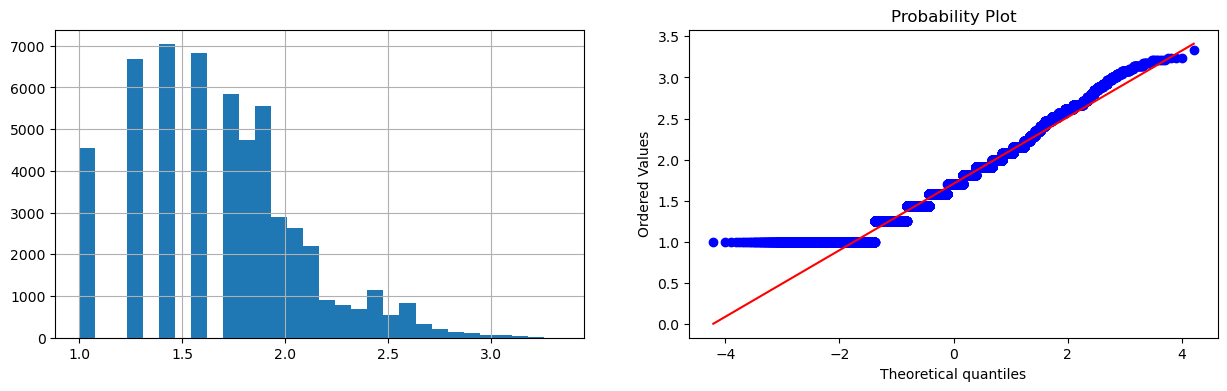

length_of_service_rec


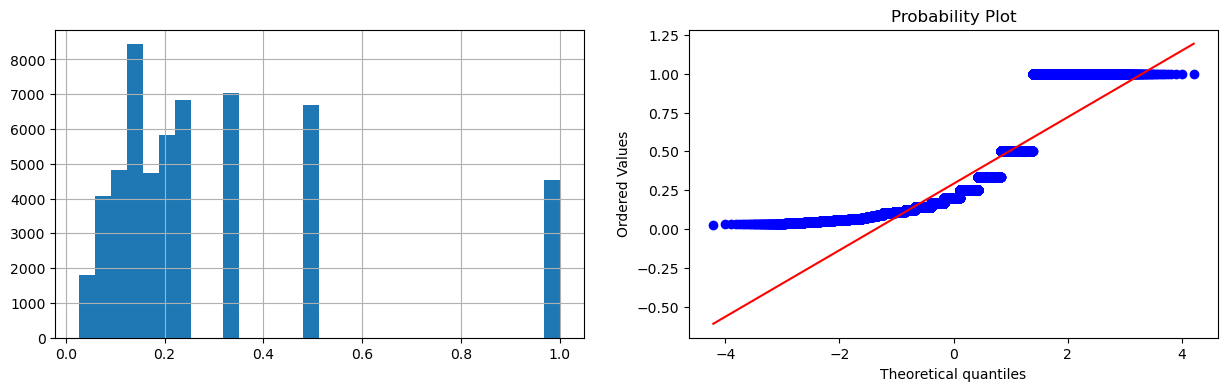

length_of_service_log


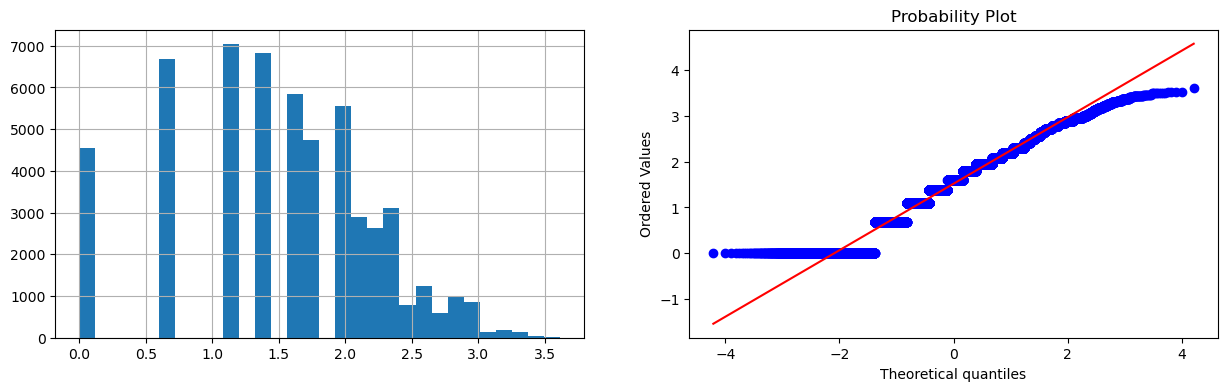

In [43]:
compare_transf(df_hr_copy, 'length_of_service')

In [44]:
#Numerical Transformation for avg_training_score

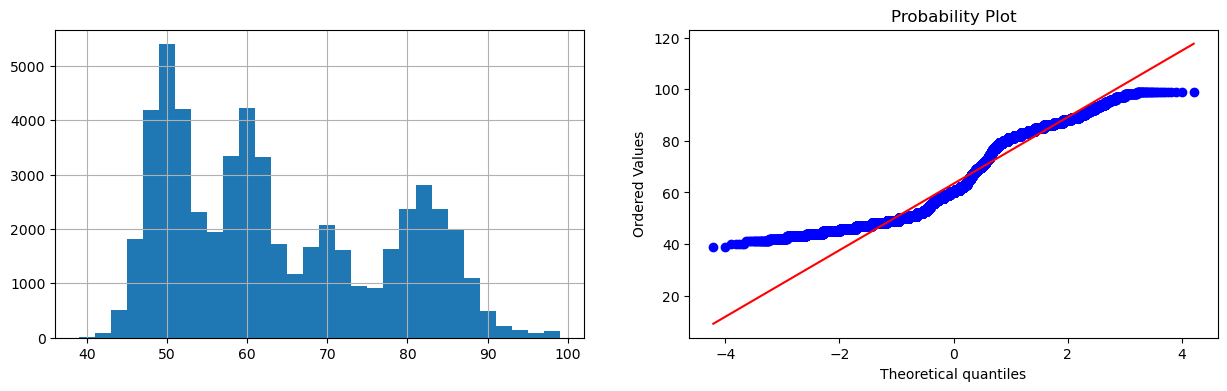

In [45]:
# Original Distribution 
diagnostic_plots_NUM(df_hr_copy, 'avg_training_score')

avg_training_score_square


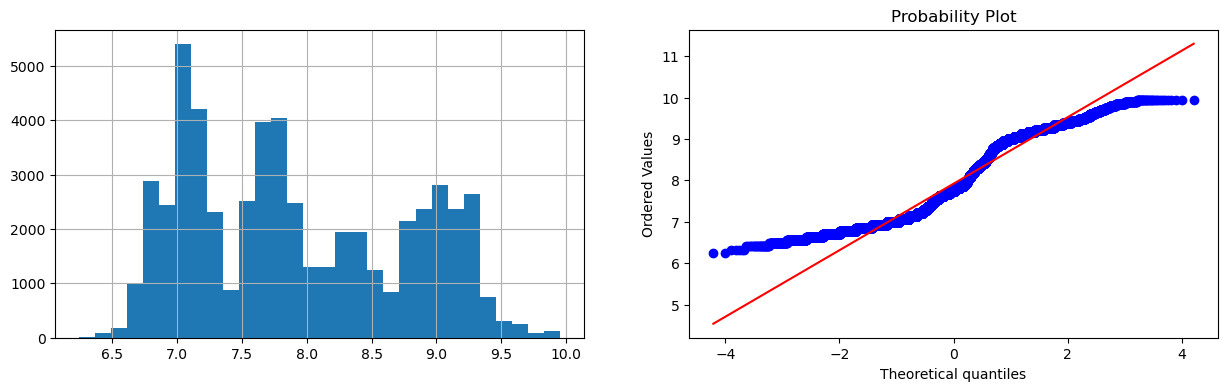

avg_training_score_cube


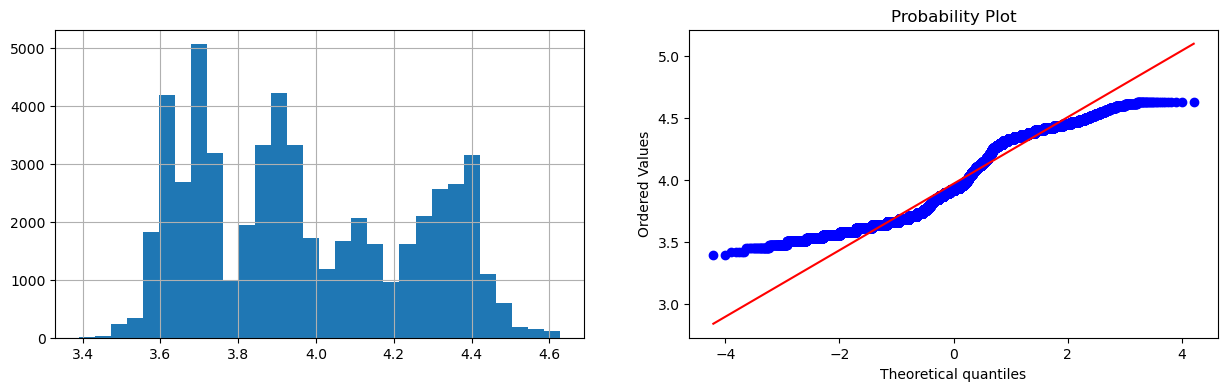

avg_training_score_rec


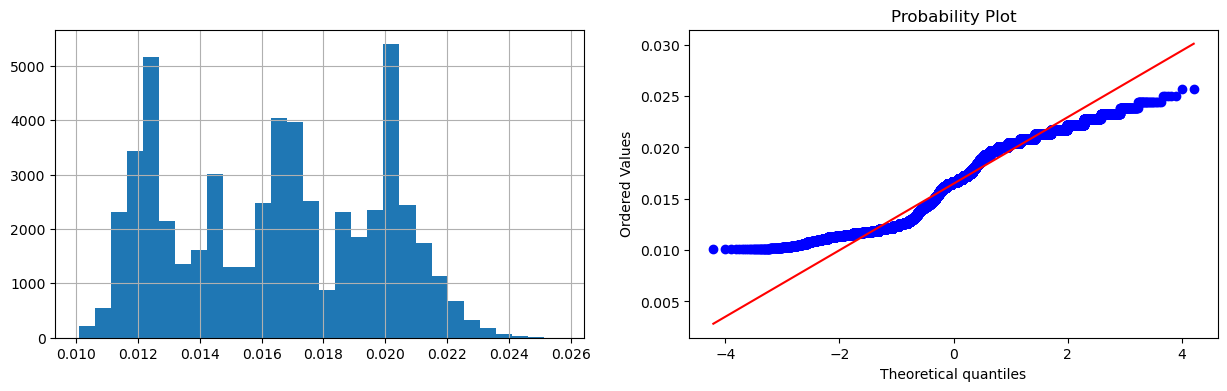

avg_training_score_log


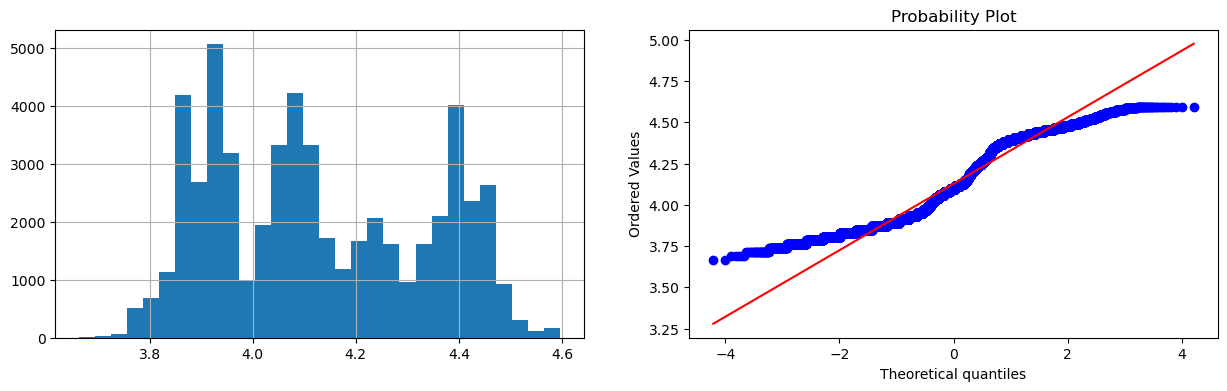

In [46]:
compare_transf(df_hr_copy, 'avg_training_score')

In [47]:
#Applying Transformation Methods

In [48]:
# age and avg_training_score

# initialize the transformer
rt = ReciprocalTransformer(variables = ['age', 'avg_training_score'])

# fit transformer to the entire dataframe
rt.fit(df_hr)

# transform the indicated variables within our data set
df_hr = rt.transform(df_hr)


# length_of_service
Transformer = PowerTransformer(variables = ['length_of_service'], exp=1/3)

# fit transformer to data 
Transformer.fit(df_hr)

# transform df_HR
df_hr = Transformer.transform(df_hr)

In [49]:
df_hr.head()

employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings       age  previous_year_rating  \
0            sourcing                1  0.028571                   5.0   
1               other                1  0.033333                   5.0   
2            sourcing                1  0.029412                   3.0   
3               other                2  0.025641                   1.0   
4               other                1  0.022222                   3.0   

   length_of_service  met_KPIs  won_awards  avg_training_score  is_promoted  
0           2.000000         1           0            0.020408            0  
1           1.587401         0           0            0.016667            0  
2           1.912931         0           0            0.020000            0  
3           2.154435         0           0            0.020000            0  
4           1.259921         0           0            0.013699            0

In [50]:
#Encoding Category data columns

In [51]:
df_hr[cat].nunique()

department              9
region                 34
education               4
gender                  2
recruitment_channel     3
dtype: int64

In [52]:
#Encoding department column

In [53]:
# Find the unique values in department
unique_values = pd.unique(df_hr['department'])

# Print the unique values
print(unique_values)

['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal']


In [54]:
department_map = {'Sales & Marketing': 1, 
                  'Operations': 2,
                  'Technology': 3,
                  'Analytics': 4,
                  'R&D': 5,
                  'Procurement': 6,
                  'Finance': 7,
                  'HR': 8,
                  'Legal': 9}

df_hr['department'] = df_hr['department'].map(department_map).astype(int)

# Show the updated DataFrame
df_hr.head()

employee_id  department     region         education gender  \
0        65438           1   region_7  Master's & above      f   
1        65141           2  region_22        Bachelor's      m   
2         7513           1  region_19        Bachelor's      m   
3         2542           1  region_23        Bachelor's      m   
4        48945           3  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings       age  previous_year_rating  \
0            sourcing                1  0.028571                   5.0   
1               other                1  0.033333                   5.0   
2            sourcing                1  0.029412                   3.0   
3               other                2  0.025641                   1.0   
4               other                1  0.022222                   3.0   

   length_of_service  met_KPIs  won_awards  avg_training_score  is_promoted  
0           2.000000         1           0            0.020408            0  
1           1.587401         0           0            0.016667            0  
2           1.912931         0           0            0.020000            0  
3           2.154435         0           0            0.020000            0  
4           1.259921         0           0            0.013699            0

In [55]:
#Encoding region column

In [56]:
# Strip away 'region_' from the 'region' column and convert the values to integers
df_hr['region'] = df_hr['region'].str.replace('region_', '').astype(int)

# Show the updated DataFrame
df_hr.head()

employee_id  department  region         education gender  \
0        65438           1       7  Master's & above      f   
1        65141           2      22        Bachelor's      m   
2         7513           1      19        Bachelor's      m   
3         2542           1      23        Bachelor's      m   
4        48945           3      26        Bachelor's      m   

  recruitment_channel  no_of_trainings       age  previous_year_rating  \
0            sourcing                1  0.028571                   5.0   
1               other                1  0.033333                   5.0   
2            sourcing                1  0.029412                   3.0   
3               other                2  0.025641                   1.0   
4               other                1  0.022222                   3.0   

   length_of_service  met_KPIs  won_awards  avg_training_score  is_promoted  
0           2.000000         1           0            0.020408            0  
1           1.587401         0           0            0.016667            0  
2           1.912931         0           0            0.020000            0  
3           2.154435         0           0            0.020000            0  
4           1.259921         0           0            0.013699            0

In [57]:
#Encoding education column

In [58]:
# Find the unique values in education
unique_values = pd.unique(df_hr['education'])

# Print the unique values
print(unique_values)

["Master's & above" "Bachelor's" 'unknown' 'Below Secondary']


In [59]:
education_map = {"Master's & above": 1, 
                  "Bachelor's": 2,
                  'unknown': 3,
                  'Below Secondary': 4}

df_hr['education'] = df_hr['education'].map(education_map).astype(int)

# Show the updated DataFrame
df_hr.head()

employee_id  department  region  education gender recruitment_channel  \
0        65438           1       7          1      f            sourcing   
1        65141           2      22          2      m               other   
2         7513           1      19          2      m            sourcing   
3         2542           1      23          2      m               other   
4        48945           3      26          2      m               other   

   no_of_trainings       age  previous_year_rating  length_of_service  \
0                1  0.028571                   5.0           2.000000   
1                1  0.033333                   5.0           1.587401   
2                1  0.029412                   3.0           1.912931   
3                2  0.025641                   1.0           2.154435   
4                1  0.022222                   3.0           1.259921   

   met_KPIs  won_awards  avg_training_score  is_promoted  
0         1           0            0.020408            0  
1         0           0            0.016667            0  
2         0           0            0.020000            0  
3         0           0            0.020000            0  
4         0           0            0.013699            0

In [60]:
#Encoding gender column

In [61]:
gender_map = {'f': 1, 'm': 2}

df_hr['gender'] = df_hr['gender'].map(gender_map).astype(int)

# Show the updated DataFrame
df_hr.head()

employee_id  department  region  education  gender recruitment_channel  \
0        65438           1       7          1       1            sourcing   
1        65141           2      22          2       2               other   
2         7513           1      19          2       2            sourcing   
3         2542           1      23          2       2               other   
4        48945           3      26          2       2               other   

   no_of_trainings       age  previous_year_rating  length_of_service  \
0                1  0.028571                   5.0           2.000000   
1                1  0.033333                   5.0           1.587401   
2                1  0.029412                   3.0           1.912931   
3                2  0.025641                   1.0           2.154435   
4                1  0.022222                   3.0           1.259921   

   met_KPIs  won_awards  avg_training_score  is_promoted  
0         1           0            0.020408            0  
1         0           0            0.016667            0  
2         0           0            0.020000            0  
3         0           0            0.020000            0  
4         0           0            0.013699            0

In [62]:
#Encoding recruitment_channel column

In [63]:
# Find the unique values in recruitment_channel
unique_values = pd.unique(df_hr['recruitment_channel'])

# Print the unique values
print(unique_values)

['sourcing' 'other' 'referred']


In [64]:
recruitment_map = {'sourcing': 1, 
                  'other': 2,
                  'referred': 3}

df_hr['recruitment_channel'] = df_hr['recruitment_channel'].map(recruitment_map).astype(int)

# Show the updated DataFrame
df_hr.head()

employee_id  department  region  education  gender  recruitment_channel  \
0        65438           1       7          1       1                    1   
1        65141           2      22          2       2                    2   
2         7513           1      19          2       2                    1   
3         2542           1      23          2       2                    2   
4        48945           3      26          2       2                    2   

   no_of_trainings       age  previous_year_rating  length_of_service  \
0                1  0.028571                   5.0           2.000000   
1                1  0.033333                   5.0           1.587401   
2                1  0.029412                   3.0           1.912931   
3                2  0.025641                   1.0           2.154435   
4                1  0.022222                   3.0           1.259921   

   met_KPIs  won_awards  avg_training_score  is_promoted  
0         1           0            0.020408            0  
1         0           0            0.016667            0  
2         0           0            0.020000            0  
3         0           0            0.020000            0  
4         0           0            0.013699            0

### 1.3 Correlation Analysis

In [65]:
# This shows the correlations between the variables
df_hr.corr()

employee_id  department    region  education    gender  \
employee_id              1.000000    0.006794  0.004310  -0.002691 -0.001542   
department               0.006794    1.000000 -0.053978  -0.017970 -0.078665   
region                   0.004310   -0.053978  1.000000   0.034708  0.106005   
education               -0.002691   -0.017970  0.034708   1.000000  0.038803   
gender                  -0.001542   -0.078665  0.106005   0.038803  1.000000   
recruitment_channel     -0.005392    0.010129 -0.014042   0.005325 -0.003145   
no_of_trainings         -0.005121   -0.005758 -0.004304   0.019408  0.084501   
age                     -0.001156    0.054773  0.212349   0.455036  0.016096   
previous_year_rating     0.002350    0.029567 -0.041752  -0.139917 -0.025053   
length_of_service        0.000822   -0.056569 -0.152818  -0.308395 -0.021814   
met_KPIs                -0.002501    0.054972 -0.009059  -0.019616 -0.037400   
won_awards               0.008420    0.003873  0.006364  -0.001317  0.002381   
avg_training_score       0.000757   -0.373096 -0.021028   0.053044  0.053298   
is_promoted              0.001206    0.001357 -0.011007  -0.032294 -0.011109   

                      recruitment_channel  no_of_trainings       age  \
employee_id                     -0.005392        -0.005121 -0.001156   
department                       0.010129        -0.005758  0.054773   
region                          -0.014042        -0.004304  0.212349   
education                        0.005325         0.019408  0.455036   
gender                          -0.003145         0.084501  0.016096   
recruitment_channel              1.000000         0.004113  0.006784   
no_of_trainings                  0.004113         1.000000  0.081000   
age                              0.006784         0.081000  1.000000   
previous_year_rating             0.015322        -0.064119 -0.220547   
length_of_service               -0.010114        -0.059150 -0.670391   
met_KPIs                         0.019480        -0.045576  0.015811   
won_awards                       0.006298        -0.007628  0.006150   
avg_training_score              -0.014333        -0.035642 -0.027289   
is_promoted                      0.005461        -0.024896  0.010373   

                      previous_year_rating  length_of_service  met_KPIs  \
employee_id                       0.002350           0.000822 -0.002501   
department                        0.029567          -0.056569  0.054972   
region                           -0.041752          -0.152818 -0.009059   
education                        -0.139917          -0.308395 -0.019616   
gender                           -0.025053          -0.021814 -0.037400   
recruitment_channel               0.015322          -0.010114  0.019480   
no_of_trainings                  -0.064119          -0.059150 -0.045576   
age                              -0.220547          -0.670391  0.015811   
previous_year_rating              1.000000           0.291352  0.274593   
length_of_service                 0.291352           1.000000 -0.067228   
met_KPIs                          0.274593          -0.067228  1.000000   
won_awards                        0.021475          -0.035939  0.097000   
avg_training_score               -0.067341           0.027001 -0.086233   
is_promoted                       0.125991          -0.007566  0.221582   

                      won_awards  avg_training_score  is_promoted  
employee_id             0.008420            0.000757     0.001206  
department              0.003873           -0.373096     0.001357  
region                  0.006364           -0.021028    -0.011007  
education              -0.001317            0.053044    -0.032294  
gender                  0.002381            0.053298    -0.011109  
recruitment_channel     0.006298           -0.014333     0.005461  
no_of_trainings        -0.007628           -0.035642    -0.024896  
age                     0.006150           -0.027289     0.010373  
pr

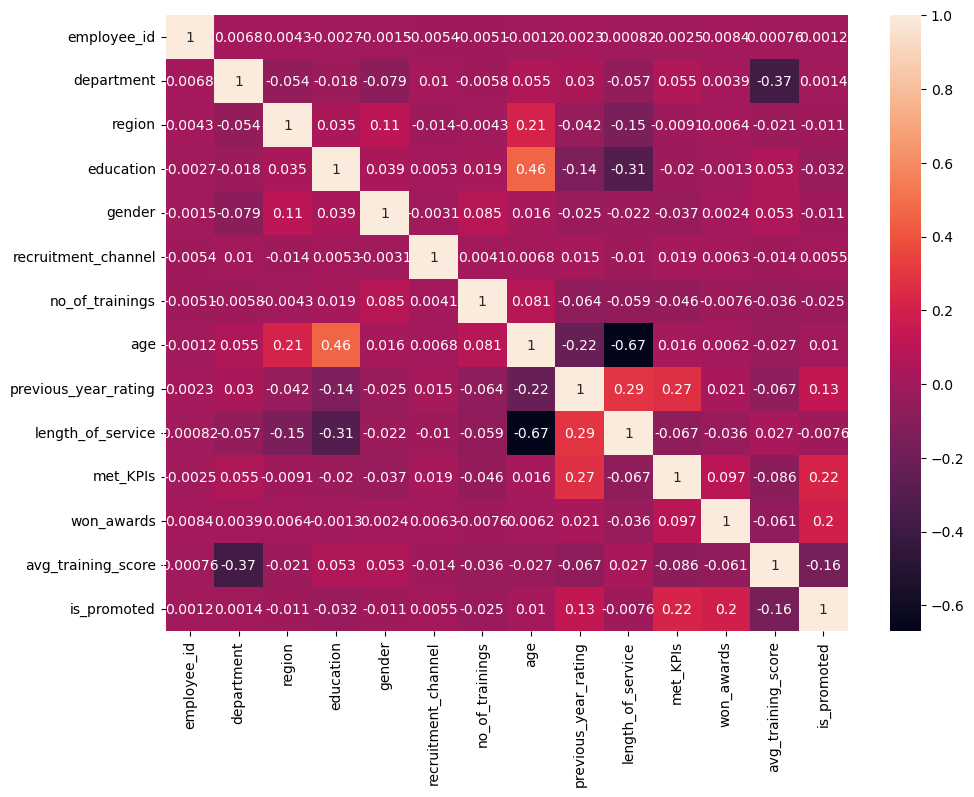

In [66]:
plt.figure(figsize=(11,8))
sns.heatmap(df_hr.corr(),annot=True)
plt.show()

In [67]:
df_hr.drop(columns=['employee_id', 'gender', 'age', 'recruitment_channel', 'length_of_service', 'region'], inplace=True)
df_hr.head()

department  education  no_of_trainings  previous_year_rating  met_KPIs  \
0           1          1                1                   5.0         1   
1           2          2                1                   5.0         0   
2           1          2                1                   3.0         0   
3           1          2                2                   1.0         0   
4           3          2                1                   3.0         0   

   won_awards  avg_training_score  is_promoted  
0           0            0.020408            0  
1           0            0.016667            0  
2           0            0.020000            0  
3           0            0.020000            0  
4           0            0.013699            0

### 1.4 Export the data

In [68]:
#exporting the data to a new CSV
df_hr.to_csv('hr_data_new.csv', index=False)

In [69]:
#FINAL DATA SET
df_hr.head()

department  education  no_of_trainings  previous_year_rating  met_KPIs  \
0           1          1                1                   5.0         1   
1           2          2                1                   5.0         0   
2           1          2                1                   3.0         0   
3           1          2                2                   1.0         0   
4           3          2                1                   3.0         0   

   won_awards  avg_training_score  is_promoted  
0           0            0.020408            0  
1           0            0.016667            0  
2           0            0.020000            0  
3           0            0.020000            0  
4           0            0.013699            0

## 2. Airbnb

### 2.1 Load and Explore the data

In [70]:
# Load dataset into a DataFrame
df = pd.read_csv('listings.csv')

# Create a copy of the DataFrame
df_bnb = df.copy()

# Show overview of the dataset
df_bnb.head()

id                                 name  host_id  host_name  \
0  49091    COZICOMFORT LONG TERM STAY ROOM 2   266763  Francesca   
1  50646      Pleasant Room along Bukit Timah   227796    Sujatha   
2  56334                          COZICOMFORT   266763  Francesca   
3  71609  Ensuite Room (Room 1 & 2) near EXPO   367042    Belinda   
4  71896      B&B  Room 1 near Airport & EXPO   367042    Belinda   

  neighbourhood_group neighbourhood  latitude  longitude     room_type  price  \
0        North Region     Woodlands   1.44255  103.79580  Private room     83   
1      Central Region   Bukit Timah   1.33235  103.78521  Private room     81   
2        North Region     Woodlands   1.44246  103.79667  Private room     69   
3         East Region      Tampines   1.34541  103.95712  Private room    206   
4         East Region      Tampines   1.34567  103.95963  Private room     94   

   minimum_nights  number_of_reviews last_review  reviews_per_month  \
0             180                  1  2013-10-21               0.01   
1              90                 18  2014-12-26               0.28   
2               6                 20  2015-10-01               0.20   
3               1                 14  2019-08-11               0.15   
4               1                 22  2019-07-28               0.22   

   calculated_host_listings_count  availability_365  
0                               2               365  
1                               1               365  
2                               2               365  
3                               9               353  
4                               9               355

In [71]:
#filtering the rows for CENTRAL Region
central_df = df_bnb.loc[df_bnb["neighbourhood_group"] == "Central Region"]

print('Before filtering:', df_bnb.shape, 
      '\nAfter filtering:', central_df.shape)

Before filtering: (7907, 16) 
After filtering: (6309, 16)


In [72]:
#filtering listings that are available for booking
print('Before filtering:', central_df.shape)
central_df = central_df[central_df['availability_365'] != 0]
print('\nAfter filtering:', central_df.shape)

Before filtering: (6309, 16)

After filtering: (5354, 16)


In [73]:
#dropping unneccesary columns
# Marking out the columns to drop 
to_drop = ['id', 'name',
           'host_id', 'host_name',
           'neighbourhood_group', 'last_review']

print('Before dropping:', central_df.shape) 

# Dropping the unwanted columns 
central_df.drop(to_drop, axis = 'columns', inplace = True)

print('After dropping:', central_df.shape)

central_df.head()

Before dropping: (5354, 16)
After dropping: (5354, 10)


neighbourhood  latitude  longitude     room_type  price  minimum_nights  \
1    Bukit Timah   1.33235  103.78521  Private room     81              90   
10   Bukit Merah   1.28875  103.80814  Private room     44              15   
11   Bukit Merah   1.28837  103.81099  Private room     40              30   
13        Newton   1.31125  103.83816  Private room     65               2   
14   Bukit Merah   1.28976  103.80896  Private room     44              30   

    number_of_reviews  reviews_per_month  calculated_host_listings_count  \
1                  18               0.28                               1   
10                 18               0.23                              32   
11                 10               0.11                              32   
13                125               1.35                               6   
14                 13               0.15                              32   

    availability_365  
1                365  
10               331  
11               276  
13               336  
14               340

In [74]:
central_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5354 entries, 1 to 7906
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   5354 non-null   object 
 1   latitude                        5354 non-null   float64
 2   longitude                       5354 non-null   float64
 3   room_type                       5354 non-null   object 
 4   price                           5354 non-null   int64  
 5   minimum_nights                  5354 non-null   int64  
 6   number_of_reviews               5354 non-null   int64  
 7   reviews_per_month               3569 non-null   float64
 8   calculated_host_listings_count  5354 non-null   int64  
 9   availability_365                5354 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 460.1+ KB


In [75]:
#Categorical data columns
bnb_cat = [c for c in central_df.columns if central_df[c].dtypes=='O']
central_df[bnb_cat].head()

neighbourhood     room_type
1    Bukit Timah  Private room
10   Bukit Merah  Private room
11   Bukit Merah  Private room
13        Newton  Private room
14   Bukit Merah  Private room

In [76]:
#Numerical data columns
bnb_num = [c for c in central_df.columns if central_df[c].dtype!='O']
central_df[bnb_num].head()

latitude  longitude  price  minimum_nights  number_of_reviews  \
1    1.33235  103.78521     81              90                 18   
10   1.28875  103.80814     44              15                 18   
11   1.28837  103.81099     40              30                 10   
13   1.31125  103.83816     65               2                125   
14   1.28976  103.80896     44              30                 13   

    reviews_per_month  calculated_host_listings_count  availability_365  
1                0.28                               1               365  
10               0.23                              32               331  
11               0.11                              32               276  
13               1.35                               6               336  
14               0.15                              32               340

In [77]:
central_df.describe()

latitude    longitude        price  minimum_nights  \
count  5354.000000  5354.000000  5354.000000     5354.000000   
mean      1.303654   103.851947   176.499440       16.491408   
std       0.016093     0.024231   229.260059       37.555200   
min       1.243870   103.765330     0.000000        1.000000   
25%       1.291360   103.840123    85.000000        2.000000   
50%       1.306325   103.850110   137.000000        3.000000   
75%       1.314377   103.862617   218.000000       14.000000   
max       1.365830   103.918220  8900.000000     1000.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count        5354.000000        3569.000000                     5354.000000   
mean           14.203213           1.179238                       52.322189   
std            30.449601           1.329712                       67.297699   
min             0.000000           0.020000                        1.000000   
25%             0.000000           0.250000                        5.000000   
50%             2.000000           0.680000                       20.000000   
75%            13.000000           1.620000                       78.000000   
max           307.000000          13.000000                      274.000000   

       availability_365  
count       5354.000000  
mean         253.863280  
std          120.584195  
min            1.000000  
25%          149.000000  
50%          316.000000  
75%          359.000000  
max          365.000000

In [78]:
central_df.nunique()

neighbourhood                       19
latitude                          3273
longitude                         3567
room_type                            3
price                              348
minimum_nights                      61
number_of_reviews                  192
reviews_per_month                  505
calculated_host_listings_count      54
availability_365                   353
dtype: int64

C:\Users\isaac\AppData\Local\Temp\ipykernel_2724\1943168939.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(central_df["price"])


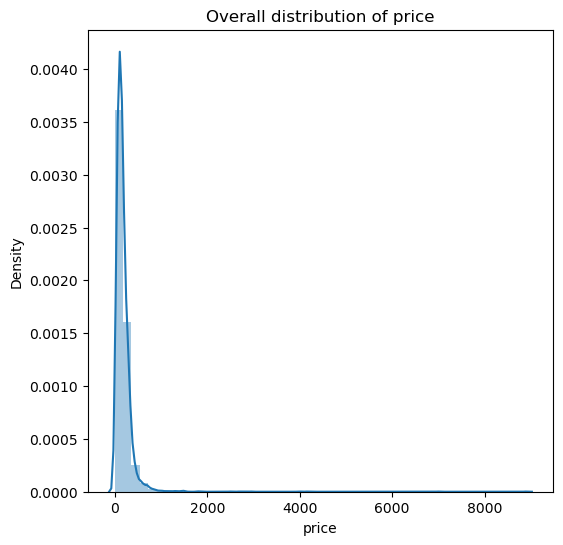

In [79]:
#Price Distribution

plt.figure(figsize = (6,6))
sns.distplot(central_df["price"])
plt.title("Overall distribution of price")
plt.show()

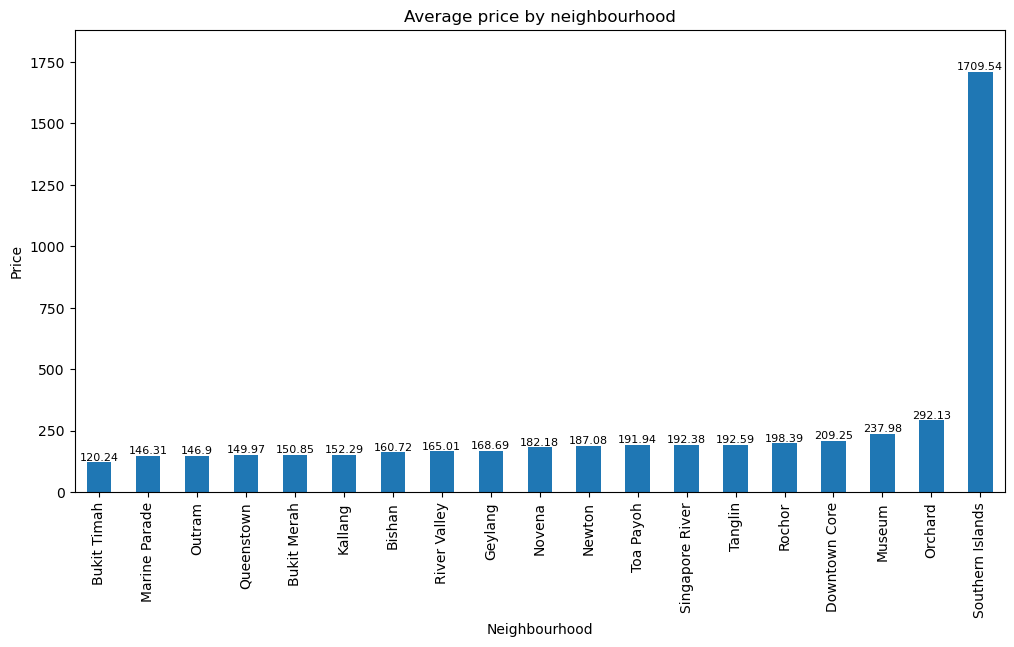

In [80]:
#Average Price by Neighbourhood

# Group the data by neighbourhood and "price" value
x = central_df.groupby(['neighbourhood'])['price'].mean()

# Sort the series by the price values
x = x.sort_values()

# Create a figure with a specified width and height
plt.figure(figsize=(12, 6))

# Create the bar chart
ax = x.plot(kind="bar", stacked=True, xlim=(-1, len(x)))

# Add data labels to the bar chart, rounding to 2 decimal places, using a smaller font size, and aligning the labels horizontally
for i, p in enumerate(ax.patches):
    ax.annotate(str(round(p.get_height(), 2)), (i, p.get_height()), ha="center", va="bottom", fontsize=8)

# Add a title, y-axis label, and x-axis label
plt.title("Average price by neighbourhood")
plt.ylabel("Price")
plt.xlabel("Neighbourhood")

# Set the x-axis ticks to evenly spaced values
plt.xticks(np.arange(len(x)))

# Set the x and y limits of the plot to the same range
plt.xlim(-0.5, len(x) - 0.5)
plt.ylim(0, x.max() * 1.1)

plt.show()


C:\Users\isaac\anaconda3\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


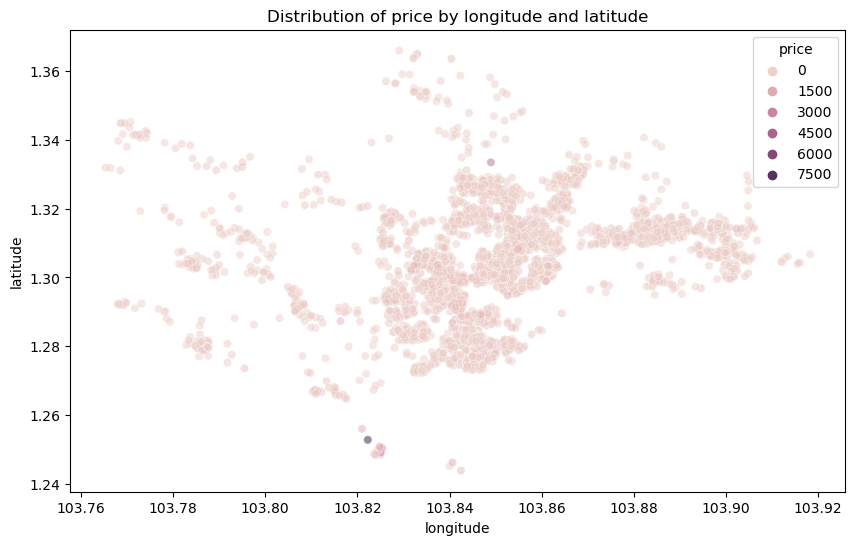

In [81]:
#Distribution of Price by Location

plt.figure(figsize=(10, 6))

# Create the scatterplot
sns.scatterplot(x="longitude", y="latitude", hue="price", data=central_df, alpha=0.5, cmap="viridis")

# Add a title
plt.title("Distribution of price by longitude and latitude")
plt.show()

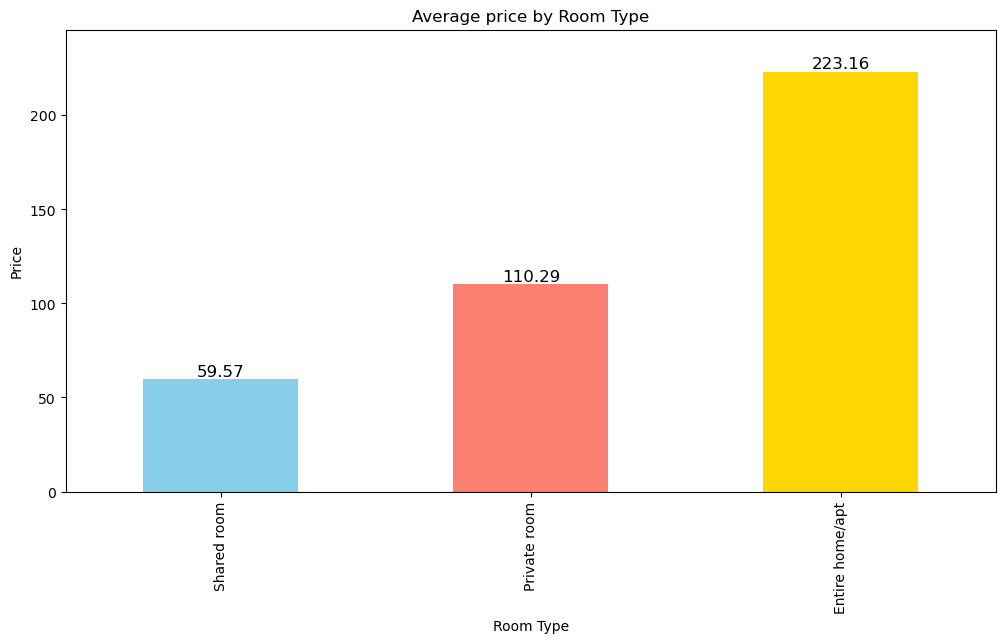

In [82]:
#Average Price by Room Type

x = central_df.groupby(['room_type'])['price'].mean()

# Sort the series by the price values
x = x.sort_values()

# Define colors for each room_type
colors = ['skyblue', 'salmon', 'gold']

# Create a figure with a specified width and height
plt.figure(figsize=(12, 6))

# Create the bar chart with specified colors
ax = x.plot(kind="bar", stacked=True, color=colors, xlim=(-1, len(x)))

# Add data labels to the bar chart, rounding to 2 decimal places, using a smaller font size, and aligning the labels horizontally
for i, p in enumerate(ax.patches):
    ax.annotate(str(round(p.get_height(), 2)), (i, p.get_height()), ha="center", va="bottom", fontsize=12)

# Add a title, y-axis label, and x-axis label
plt.title("Average price by Room Type")
plt.ylabel("Price")
plt.xlabel("Room Type")

# Set the x-axis ticks to evenly spaced values
plt.xticks(np.arange(len(x)))

# Set the x and y limits of the plot to the same range
plt.xlim(-0.5, len(x) - 0.5)
plt.ylim(0, x.max() * 1.1)

plt.show()


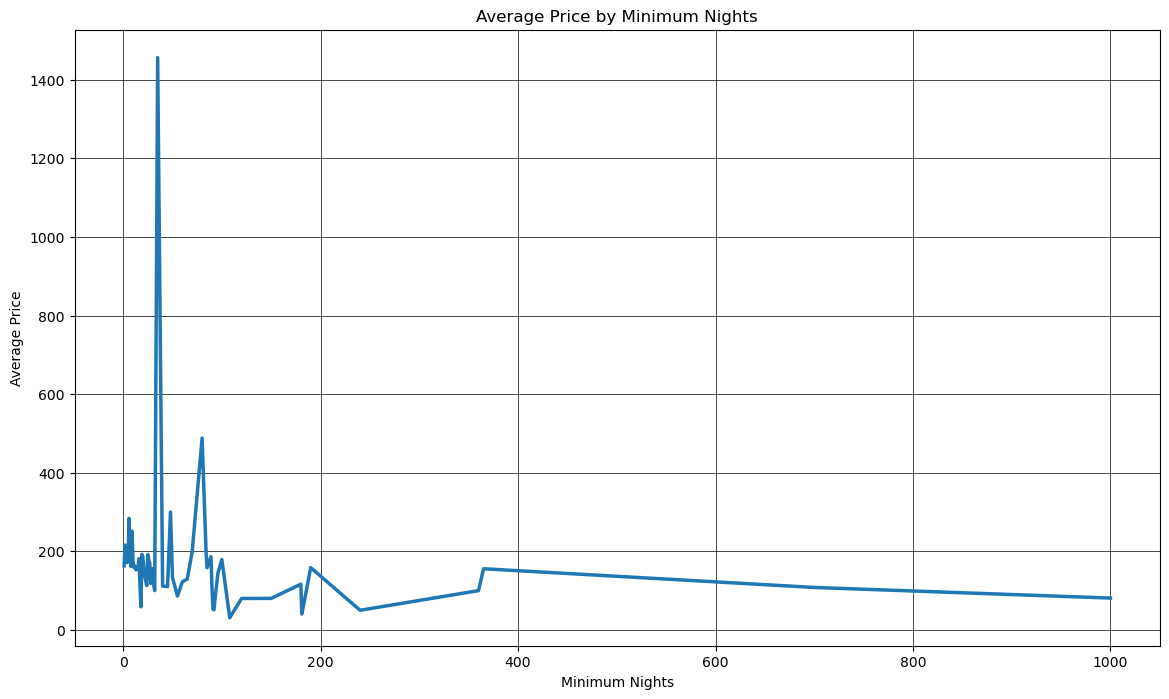

In [83]:
#Average price by minimum nights

# Group the data by minimum_nights and calculate the mean price
y = central_df.groupby('minimum_nights')['price'].mean()

# Set the figure size
plt.figure(figsize=(14, 8))

# Create the line plot
plt.plot(y, linewidth=2.5)

# Add gridlines
plt.grid(color='black', linestyle='-', linewidth=0.5)

plt.title('Average Price by Minimum Nights')
plt.xlabel('Minimum Nights')
plt.ylabel('Average Price')

plt.show()

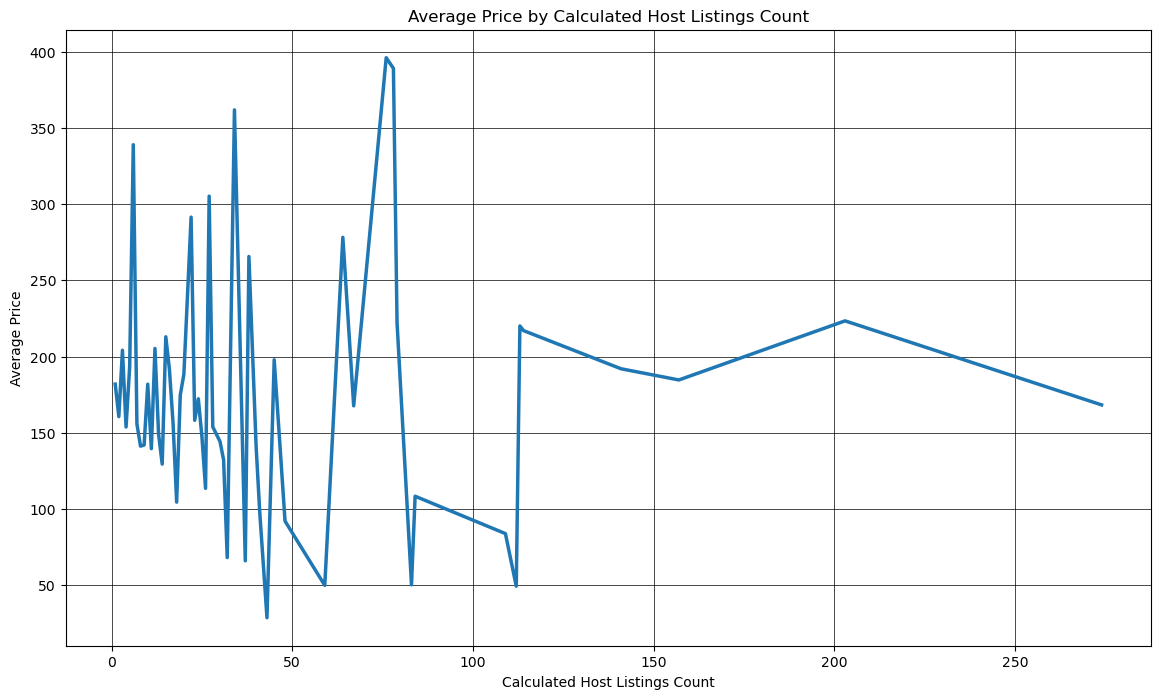

In [84]:
#Average Price by Calculated Host Listings Count

# Group the data by minimum_nights and calculate the mean price
y = central_df.groupby('calculated_host_listings_count')['price'].mean()

# Set the figure size
plt.figure(figsize=(14, 8))

# Create the line plot
plt.plot(y, linewidth=2.5)

# Add gridlines
plt.grid(color='black', linestyle='-', linewidth=0.5)

plt.title('Average Price by Calculated Host Listings Count')
plt.xlabel('Calculated Host Listings Count')
plt.ylabel('Average Price')

plt.show()

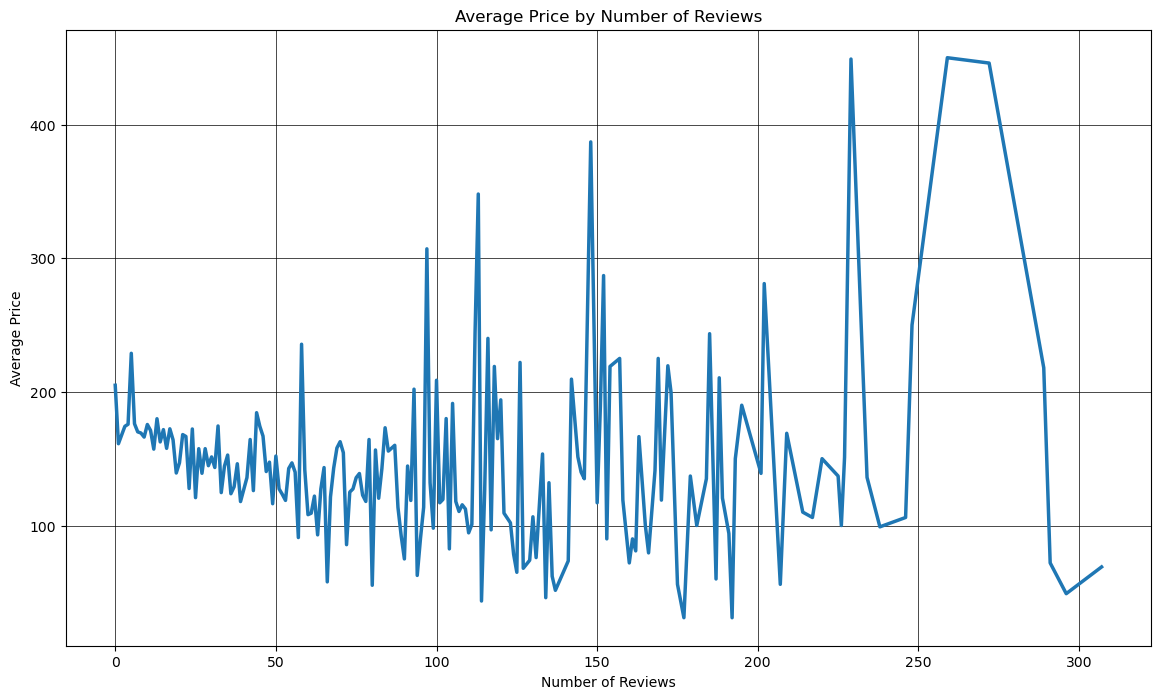

In [85]:
#Average Price by Number of Reviews

# Group the data by minimum_nights and calculate the mean price
y = central_df.groupby('number_of_reviews')['price'].mean()

# Set the figure size
plt.figure(figsize=(14, 8))

# Create the line plot
plt.plot(y, linewidth=2.5)

# Add gridlines
plt.grid(color='black', linestyle='-', linewidth=0.5)

plt.title('Average Price by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Average Price')

plt.show()

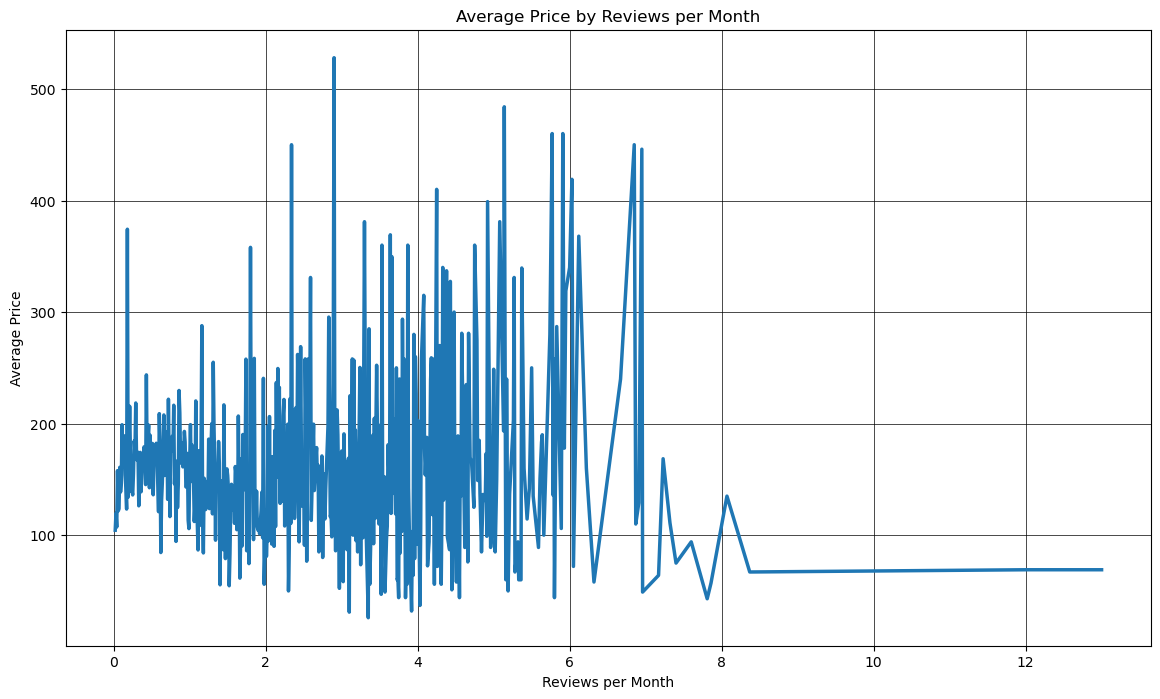

In [86]:
#Average Price by Reviews per Month

# Group the data by minimum_nights and calculate the mean price
y = central_df.groupby('reviews_per_month')['price'].mean()

# Set the figure size
plt.figure(figsize=(14, 8))

# Create the line plot
plt.plot(y, linewidth=2.5)

# Add gridlines
plt.grid(color='black', linestyle='-', linewidth=0.5)

plt.title('Average Price by Reviews per Month')
plt.xlabel('Reviews per Month')
plt.ylabel('Average Price')

plt.show()

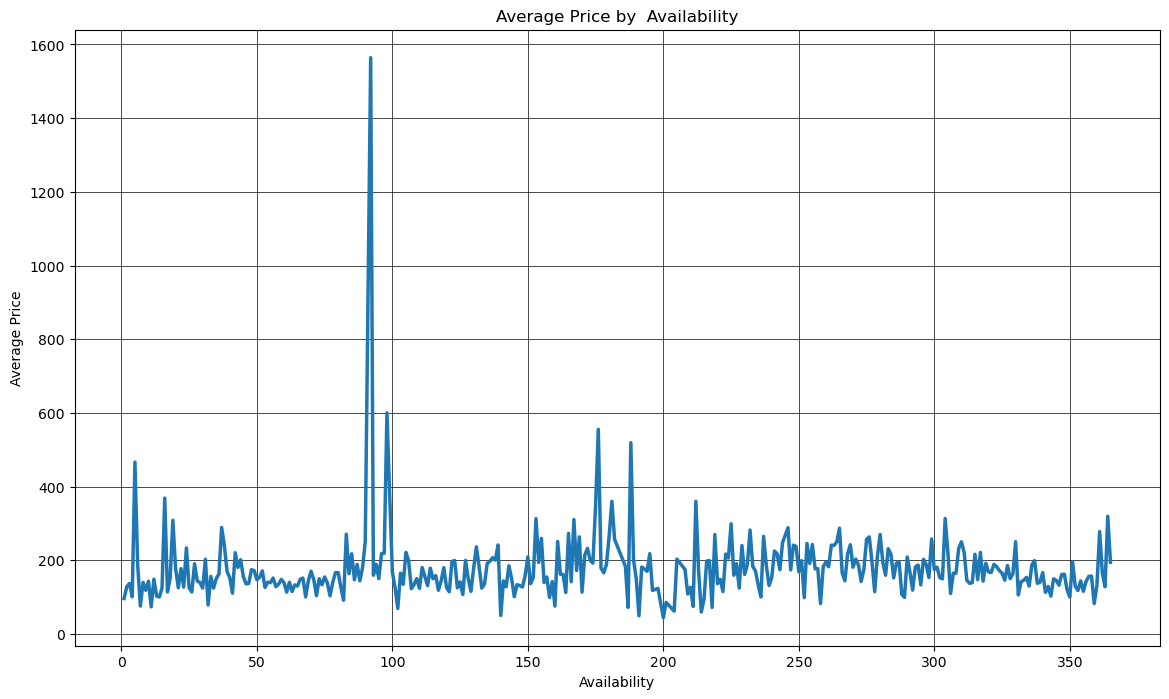

In [87]:
#Average Price by Availability

# Group the data by minimum_nights and calculate the mean price
y = central_df.groupby('availability_365')['price'].mean()

# Set the figure size
plt.figure(figsize=(14, 8))

# Create the line plot
plt.plot(y, linewidth=2.5)

# Add gridlines
plt.grid(color='black', linestyle='-', linewidth=0.5)

plt.title('Average Price by  Availability')
plt.xlabel('Availability')
plt.ylabel('Average Price')

plt.show()

### 2.2 Cleanse and Transform the data

In [88]:
#Missing Values
central_df.isnull().sum()

neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 1785
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [89]:
#Reviews_per_month Missing values

In [90]:
central_df[central_df['reviews_per_month'].isnull()].head()

neighbourhood  latitude  longitude     room_type  price  minimum_nights  \
18       Geylang   1.31420  103.90232  Private room     81              90   
26        Rochor   1.30109  103.85234  Private room    167             180   
37    Queenstown   1.28342  103.78585  Private room    128               3   
46       Kallang   1.31357  103.85731  Private room    100             365   
82        Novena   1.32359  103.84980  Private room     31             108   

    number_of_reviews  reviews_per_month  calculated_host_listings_count  \
18                  0                NaN                               1   
26                  0                NaN                               1   
37                  0                NaN                               1   
46                  0                NaN                               1   
82                  0                NaN                               1   

    availability_365  
18               173  
26               365  
37               365  
46               365  
82               365

In [91]:
#check if null values is value 0
null_reviews_per_month = central_df[central_df['reviews_per_month'].isnull()]
null_reviews_per_month_with_zero_reviews = null_reviews_per_month[null_reviews_per_month['number_of_reviews'] == 0]

if null_reviews_per_month_with_zero_reviews.shape[0] == null_reviews_per_month.shape[0]:
    print("All rows with null values in the 'reviews_per_month' column have a value of 0 in the 'number_of_reviews' column.")
else:
    print("Not all rows with null values in the 'reviews_per_month' column have a value of 0 in the 'number_of_reviews' column.")


All rows with null values in the 'reviews_per_month' column have a value of 0 in the 'number_of_reviews' column.


In [92]:
central_df['reviews_per_month'] = central_df['reviews_per_month'].fillna(0)

# Check if there is still missing values
central_df.isnull().sum()

neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [93]:
#Outliers

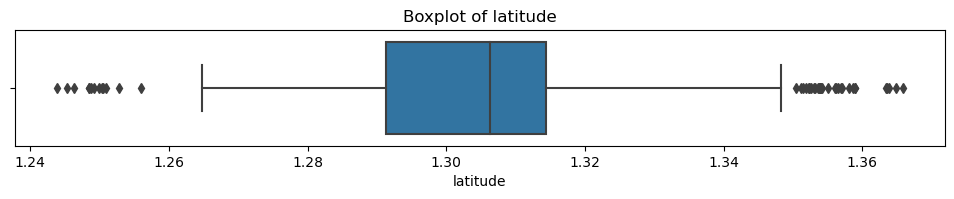

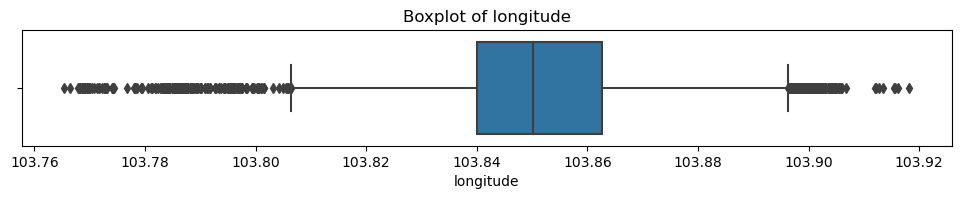

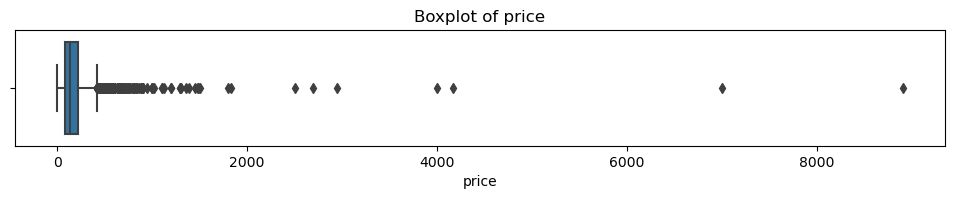

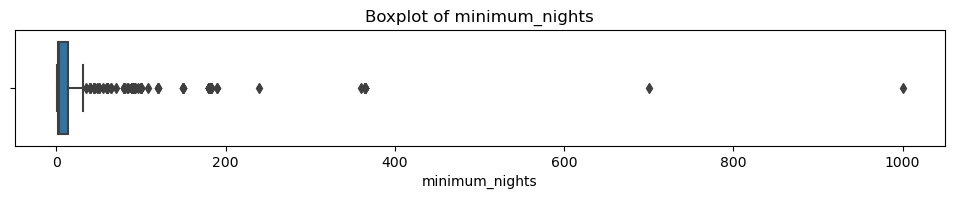

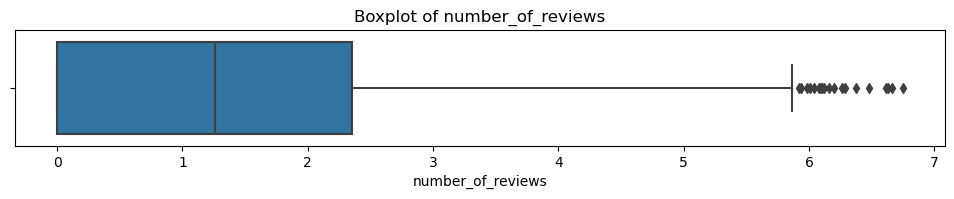

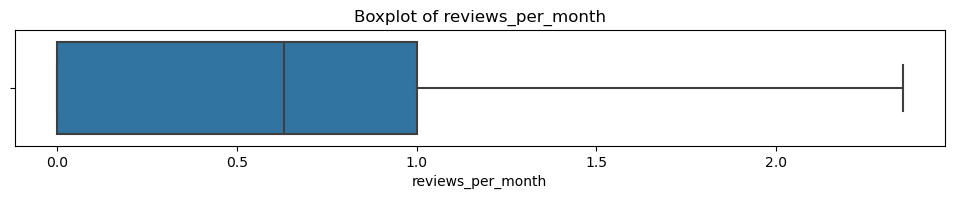

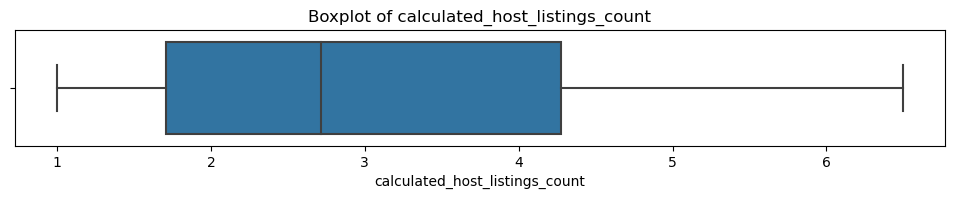

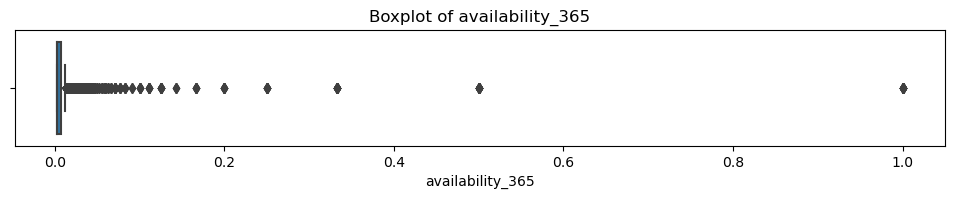

In [137]:
for column in bnb_num:
    plt.figure(figsize=(12, 1.5))
    sns.boxplot(x=central_df[column])  # Assuming you want boxplots vertically
    plt.title(f'Boxplot of {column}')
    plt.show()

In [95]:
#Records with minimum_nights more than 365(a year)
min_nights_rows = central_df[central_df['minimum_nights'] > 365]
min_nights_rows

neighbourhood  latitude  longitude        room_type  price  \
3304       Tanglin   1.31743  103.82931     Private room     81   
4226    Queenstown   1.28064  103.78516  Entire home/apt    108   

      minimum_nights  number_of_reviews  reviews_per_month  \
3304            1000                  0               0.00   
4226             700                  2               0.14   

      calculated_host_listings_count  availability_365  
3304                               3               365  
4226                               1               358

In [96]:
#Record with the highest number_of_reviews value
max_review_row = central_df.loc[central_df['number_of_reviews'].idxmax()]
max_review_row

neighbourhood                           Outram
latitude                               1.28448
longitude                             103.8436
room_type                         Private room
price                                       69
minimum_nights                               1
number_of_reviews                          307
reviews_per_month                         5.44
calculated_host_listings_count               3
availability_365                           315
Name: 140, dtype: object

In [97]:
year = (max_review_row.number_of_reviews / max_review_row.reviews_per_month)/12
print(year)

4.70281862745098


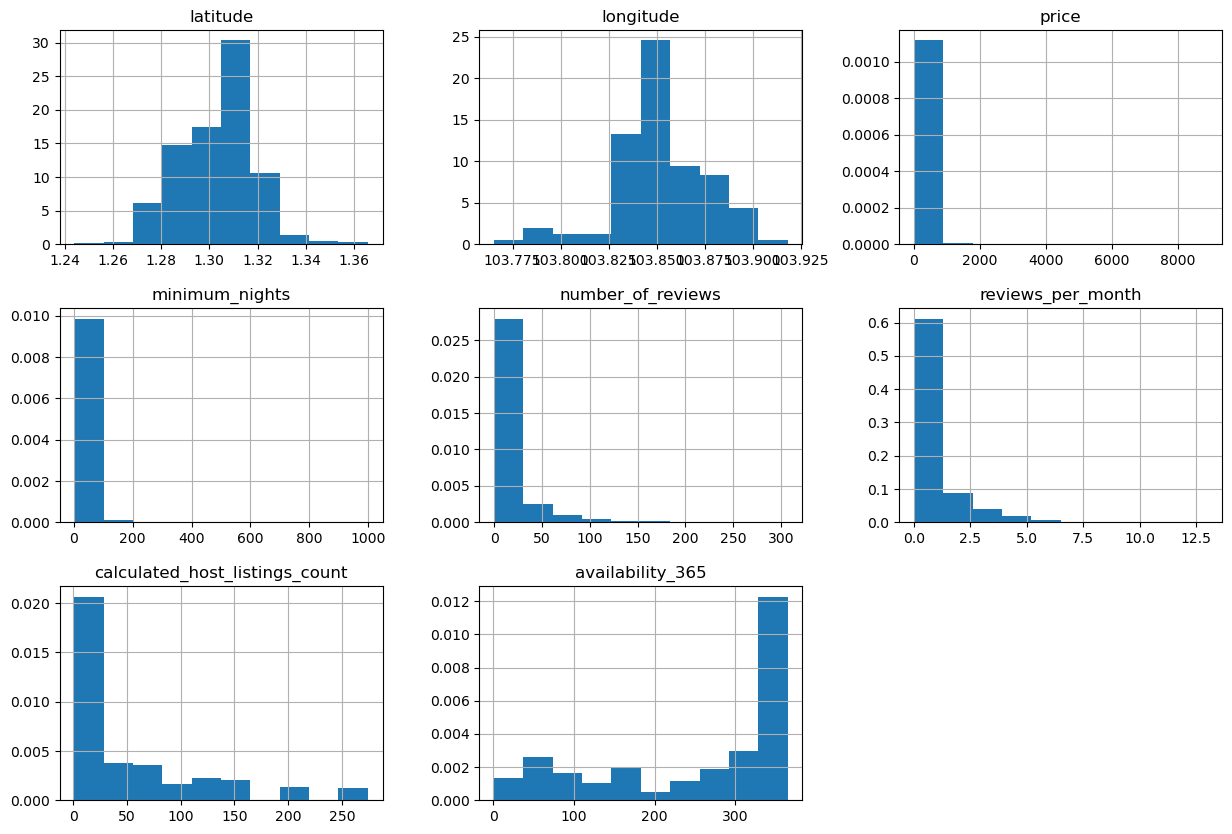

In [98]:
#Numerical Transformations
central_df.hist(figsize=(15,10), density=True)
plt.show()

In [99]:
#Create a copy of the dataframe 
central_df_copy = central_df.copy(deep=True)
variables_toTransform = ['minimum_nights', 'number_of_reviews',
                         'reviews_per_month', 'calculated_host_listings_count',
                         'availability_365']
central_df_copy.head()

neighbourhood  latitude  longitude     room_type  price  minimum_nights  \
1    Bukit Timah   1.33235  103.78521  Private room     81              90   
10   Bukit Merah   1.28875  103.80814  Private room     44              15   
11   Bukit Merah   1.28837  103.81099  Private room     40              30   
13        Newton   1.31125  103.83816  Private room     65               2   
14   Bukit Merah   1.28976  103.80896  Private room     44              30   

    number_of_reviews  reviews_per_month  calculated_host_listings_count  \
1                  18               0.28                               1   
10                 18               0.23                              32   
11                 10               0.11                              32   
13                125               1.35                               6   
14                 13               0.15                              32   

    availability_365  
1                365  
10               331  
11               276  
13               336  
14               340

In [100]:
#Performing Transformation

In [101]:
# Square root transformation
for column in variables_toTransform:
    central_df_copy[column+'_square']=central_df_copy[column]**(1/2)
    
# cube root transformation
for column in variables_toTransform:
    central_df_copy[column+'_cube']=central_df_copy[column]**(1/3)
    
# Log Transformation
for column in variables_toTransform:
    central_df_copy[column+'_log'] = np.log(central_df_copy[column])
    
# Reciprocal transformation
for column in variables_toTransform:
    central_df_copy[column+'_rec']=1/(central_df_copy[column])

C:\Users\isaac\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\isaac\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [102]:
#Check that the transformations are done
central_df_copy.head()

neighbourhood  latitude  longitude     room_type  price  minimum_nights  \
1    Bukit Timah   1.33235  103.78521  Private room     81              90   
10   Bukit Merah   1.28875  103.80814  Private room     44              15   
11   Bukit Merah   1.28837  103.81099  Private room     40              30   
13        Newton   1.31125  103.83816  Private room     65               2   
14   Bukit Merah   1.28976  103.80896  Private room     44              30   

    number_of_reviews  reviews_per_month  calculated_host_listings_count  \
1                  18               0.28                               1   
10                 18               0.23                              32   
11                 10               0.11                              32   
13                125               1.35                               6   
14                 13               0.15                              32   

    availability_365  ...  minimum_nights_log  number_of_reviews_log  \
1                365  ...            4.499810               2.890372   
10               331  ...            2.708050               2.890372   
11               276  ...            3.401197               2.302585   
13               336  ...            0.693147               4.828314   
14               340  ...            3.401197               2.564949   

    reviews_per_month_log  calculated_host_listings_count_log  \
1               -1.272966                            0.000000   
10              -1.469676                            3.465736   
11              -2.207275                            3.465736   
13               0.300105                            1.791759   
14              -1.897120                            3.465736   

    availability_365_log  minimum_nights_rec  number_of_reviews_rec  \
1               5.899897            0.011111               0.055556   
10              5.802118            0.066667               0.055556   
11              5.620401            0.033333               0.100000   
13              5.817111            0.500000               0.008000   
14              5.828946            0.033333               0.076923   

    reviews_per_month_rec  calculated_host_listings_count_rec  \
1                3.571429                            1.000000   
10               4.347826                            0.031250   
11               9.090909                            0.031250   
13               0.740741                            0.166667   
14               6.666667                            0.031250   

    availability_365_rec  
1               0.002740  
10              0.003021  
11              0.003623  
13              0.002976  
14              0.002941  

[5 rows x 30 columns]

In [103]:
#Numerical Transformation for minimum_nights

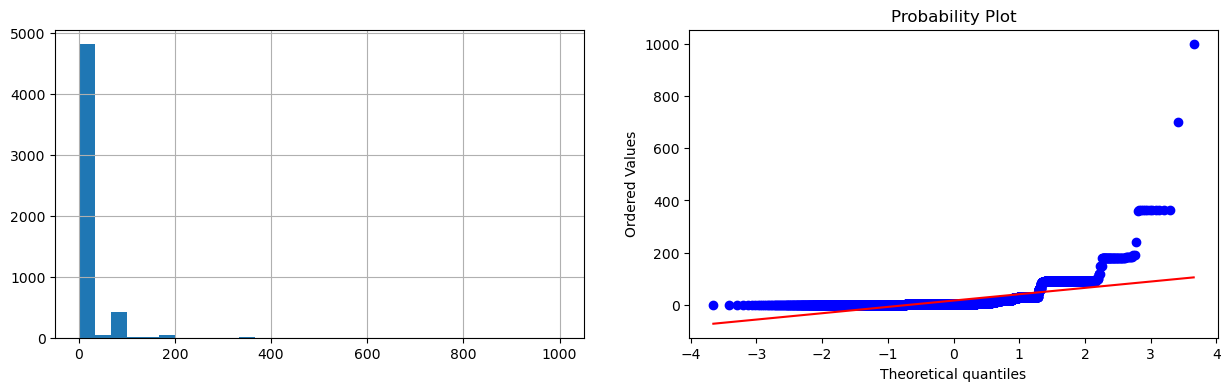

In [104]:
# Original Distribution 
diagnostic_plots_NUM(central_df_copy, 'minimum_nights')

minimum_nights_square


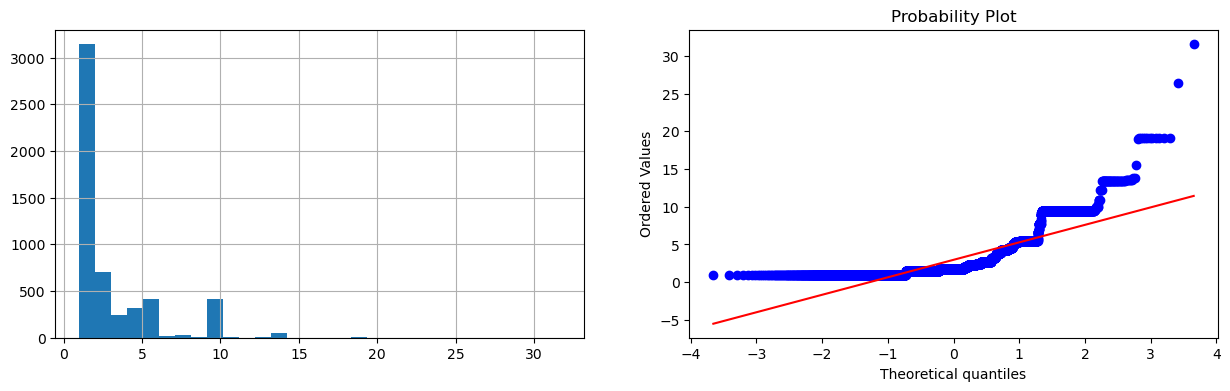

minimum_nights_cube


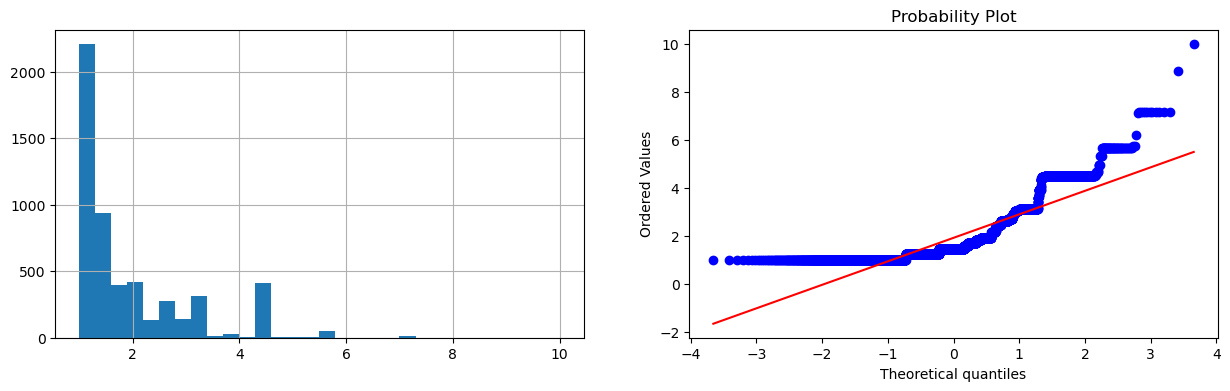

minimum_nights_rec


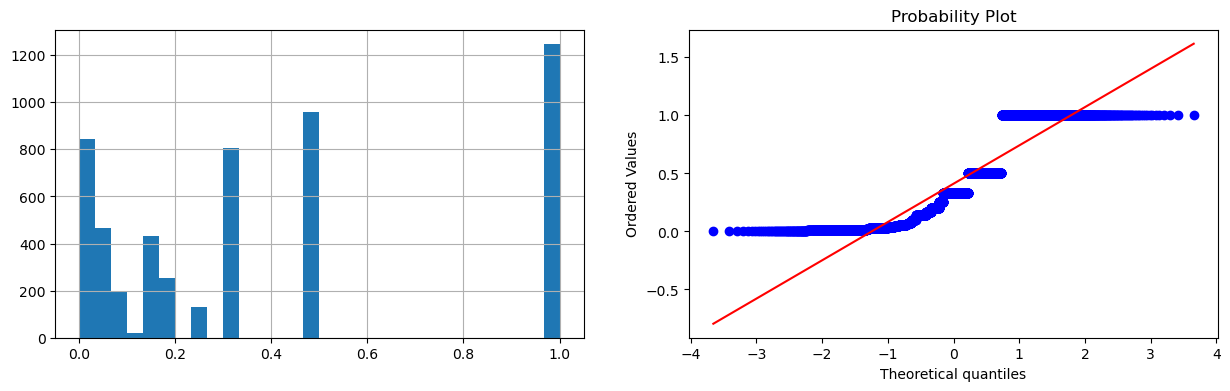

minimum_nights_log


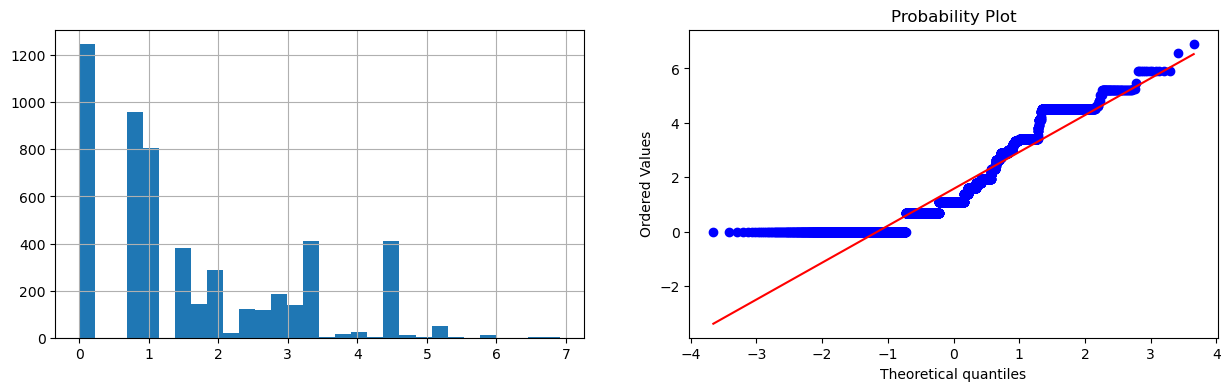

In [105]:
compare_transf(central_df_copy, 'minimum_nights')

In [106]:
#Numerical Transformation for number_of_reviews

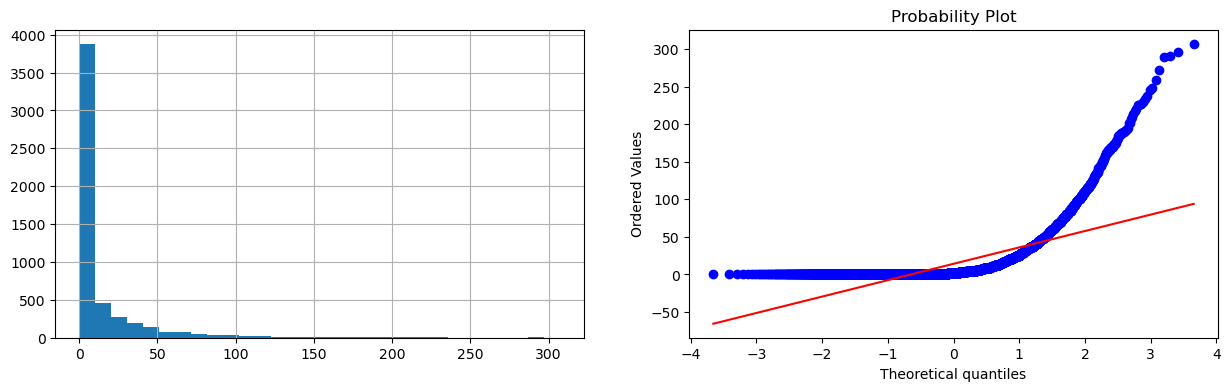

In [107]:
# Original Distribution 
diagnostic_plots_NUM(central_df_copy, 'number_of_reviews')

number_of_reviews_square


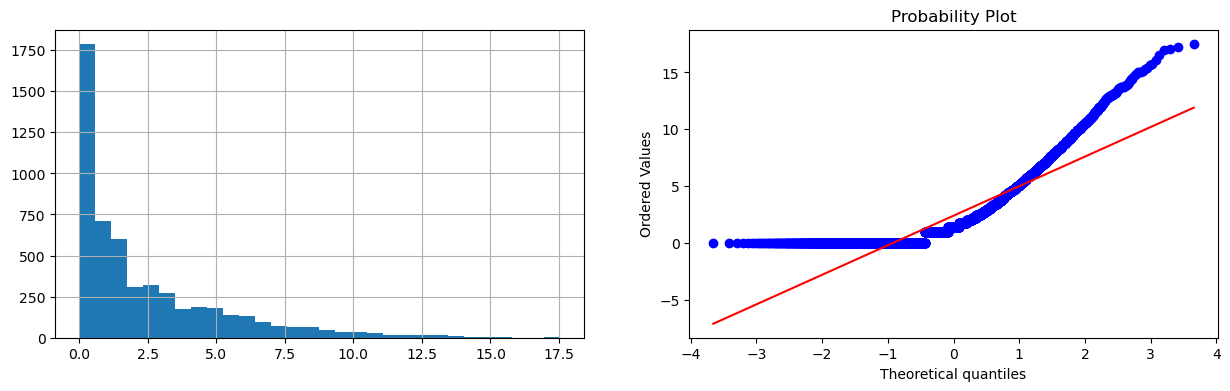

number_of_reviews_cube


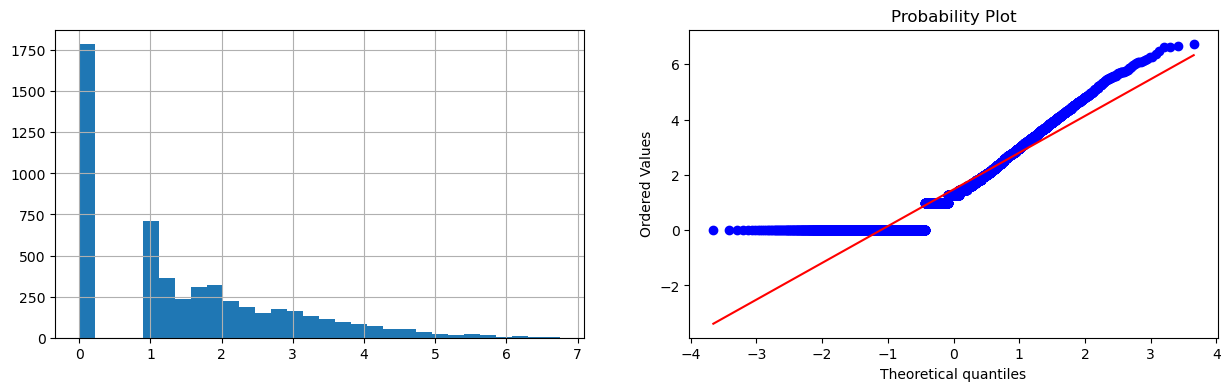

number_of_reviews_rec


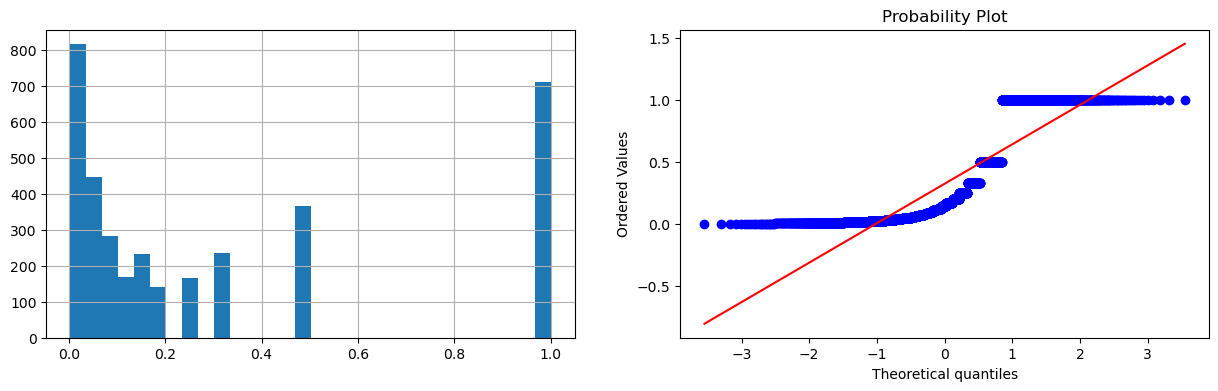

number_of_reviews_log


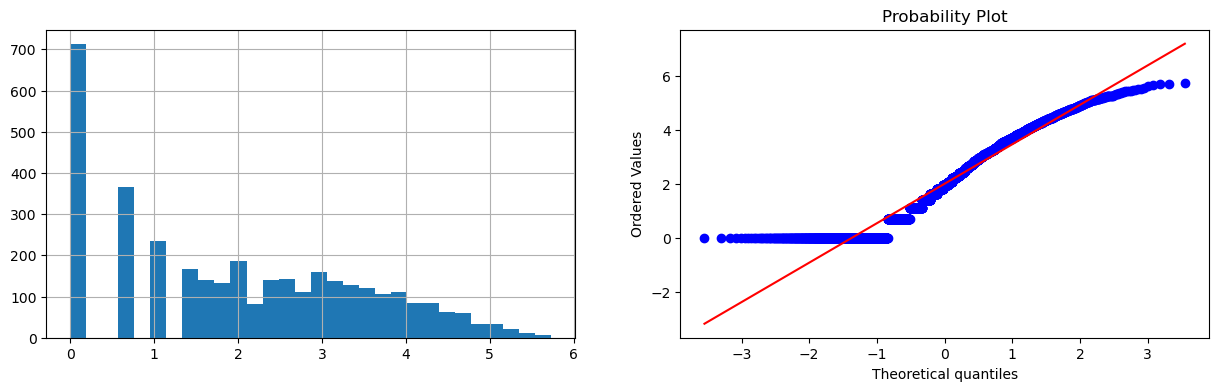

In [108]:
compare_transf(central_df_copy, 'number_of_reviews')

In [109]:
#Numerical Transformation for reviews_per_month

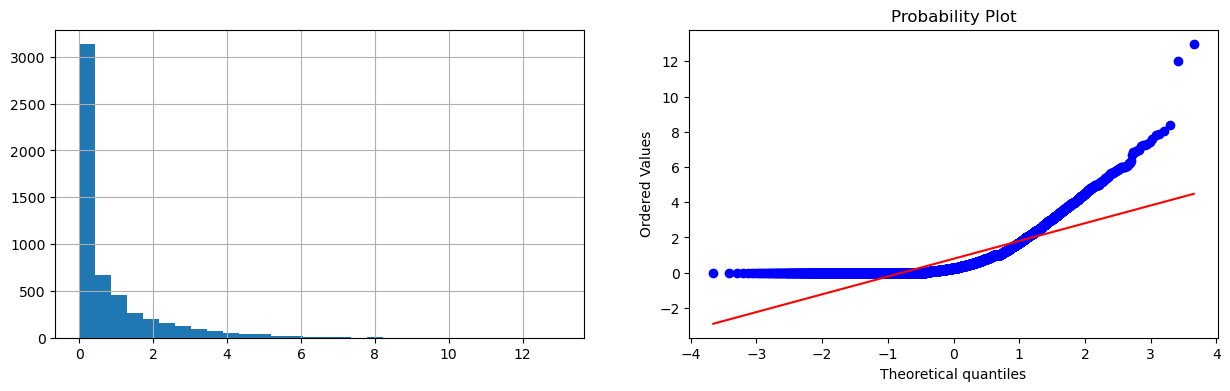

In [110]:
# Original Distribution 
diagnostic_plots_NUM(central_df_copy, 'reviews_per_month')

reviews_per_month_square


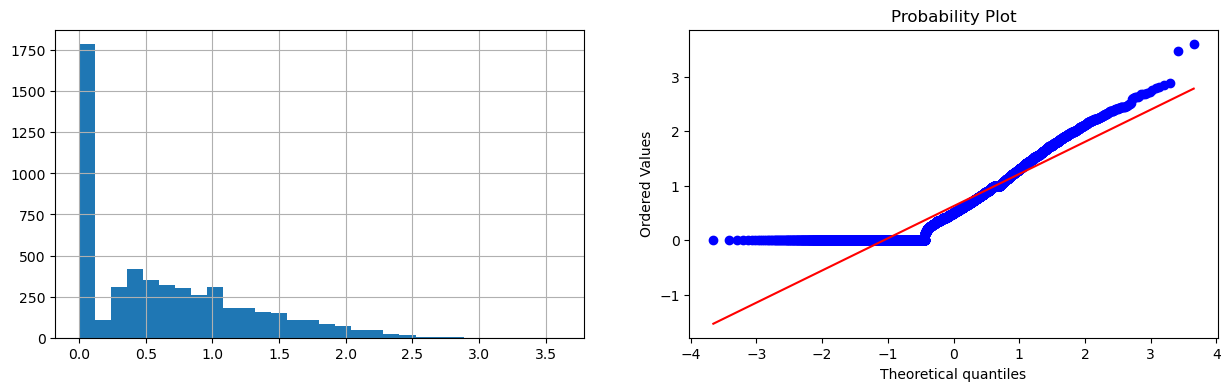

reviews_per_month_cube


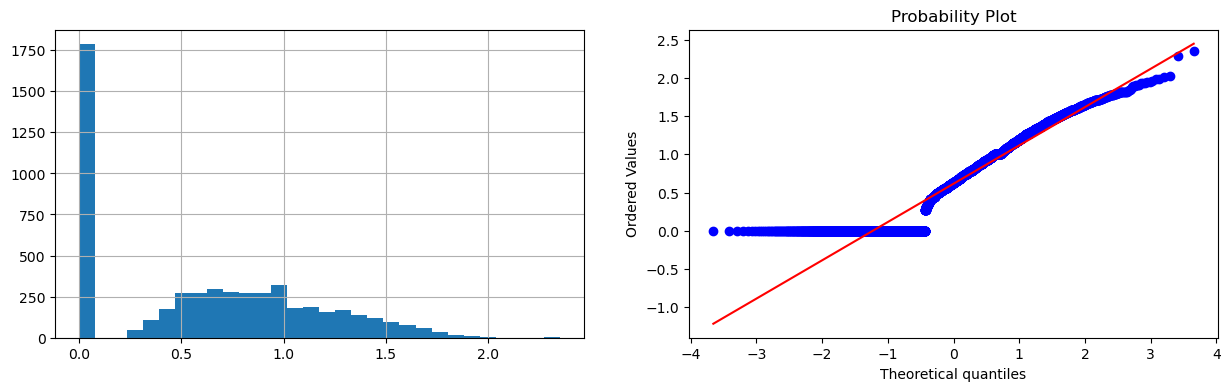

reviews_per_month_rec


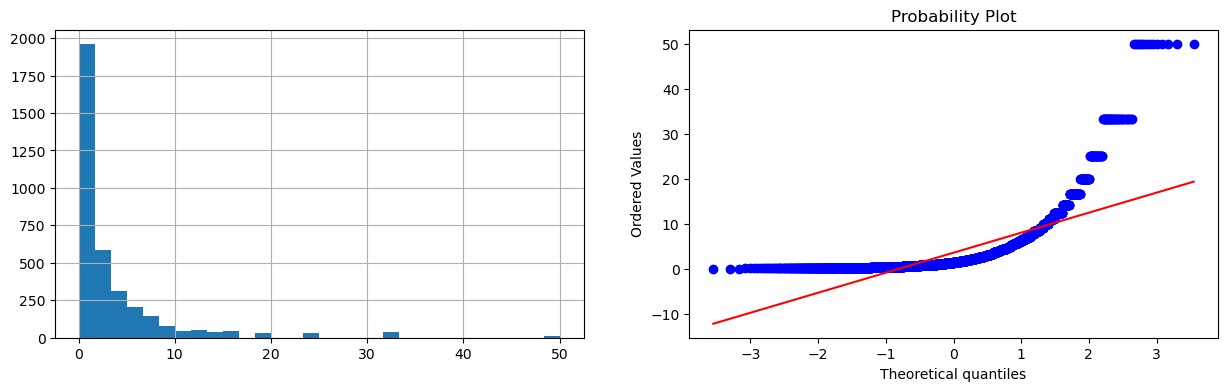

reviews_per_month_log


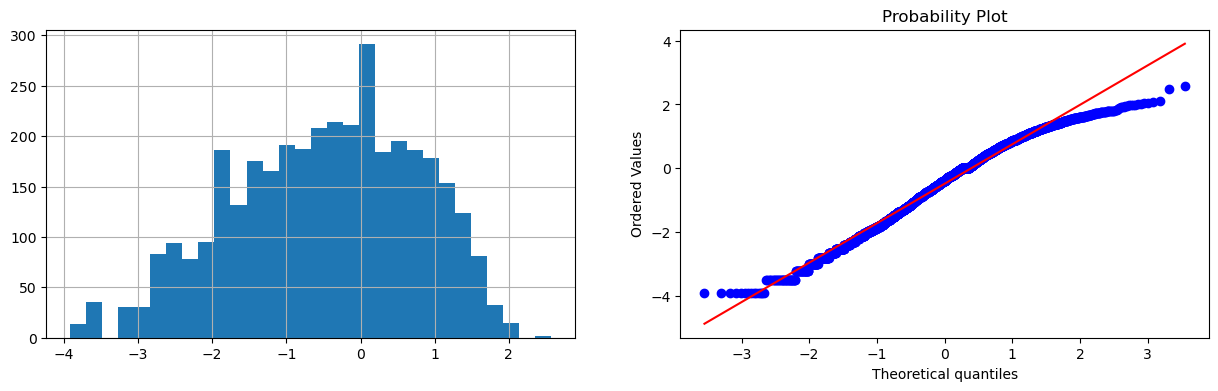

In [111]:
compare_transf(central_df_copy, 'reviews_per_month')

In [112]:
#Numerical Transformation for calculated_host_listings_count

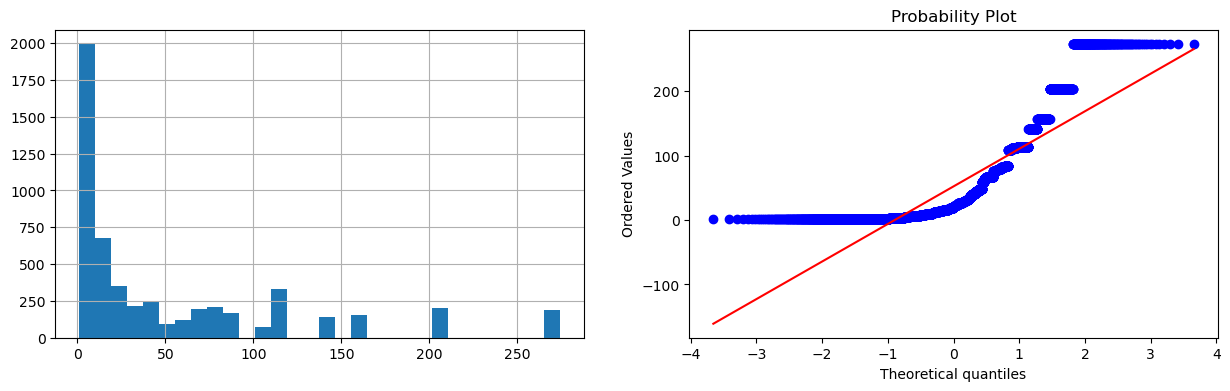

In [113]:
# Original Distribution 
diagnostic_plots_NUM(central_df_copy, 'calculated_host_listings_count')

calculated_host_listings_count_square


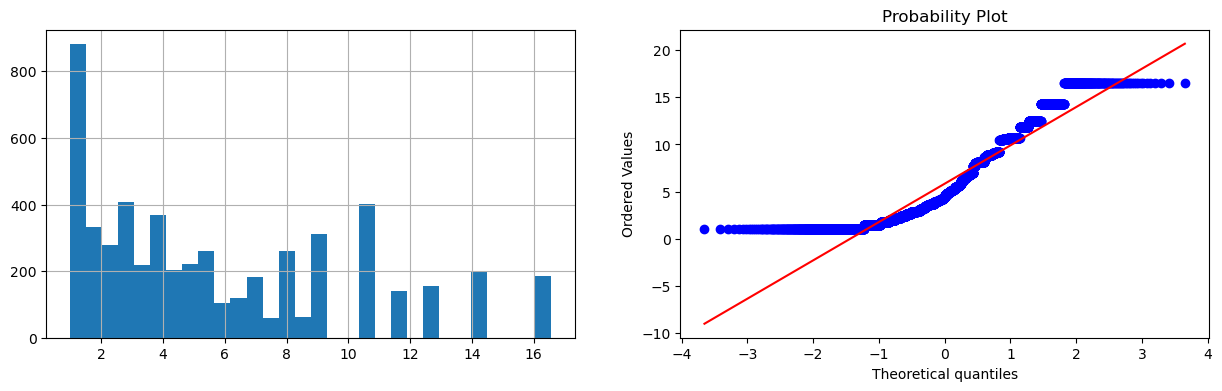

calculated_host_listings_count_cube


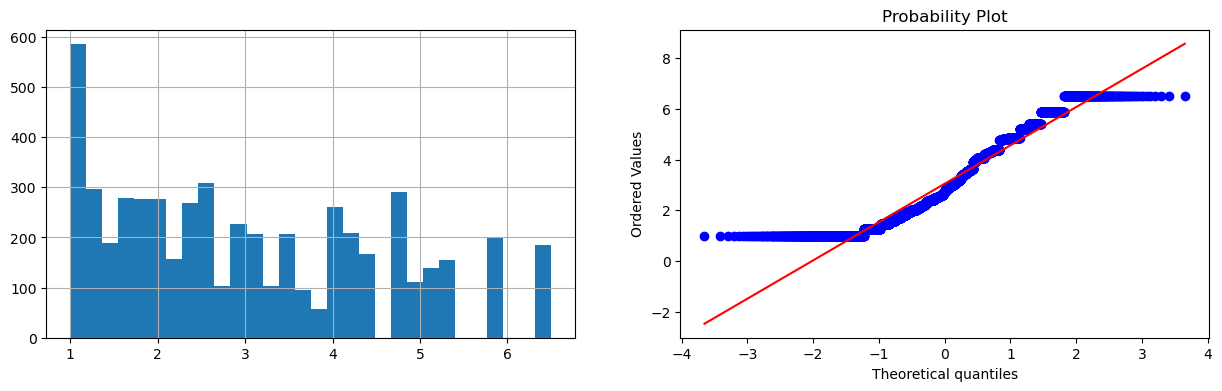

calculated_host_listings_count_rec


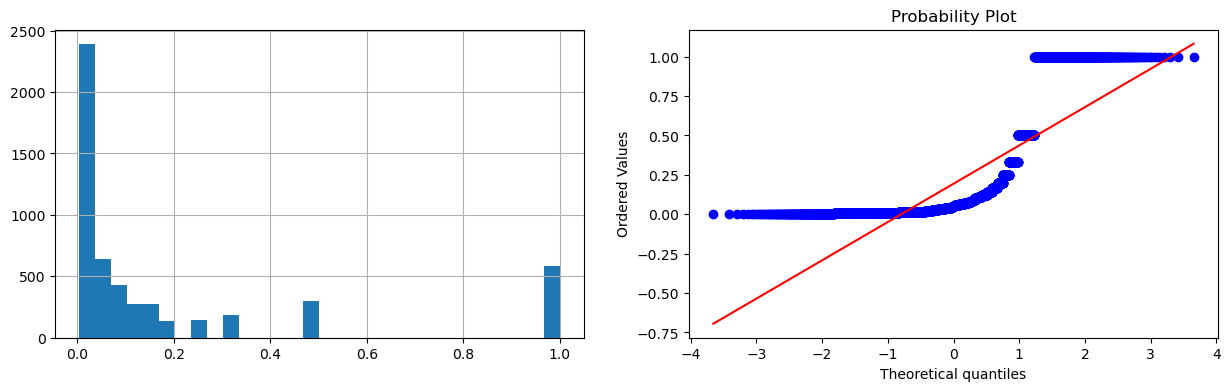

calculated_host_listings_count_log


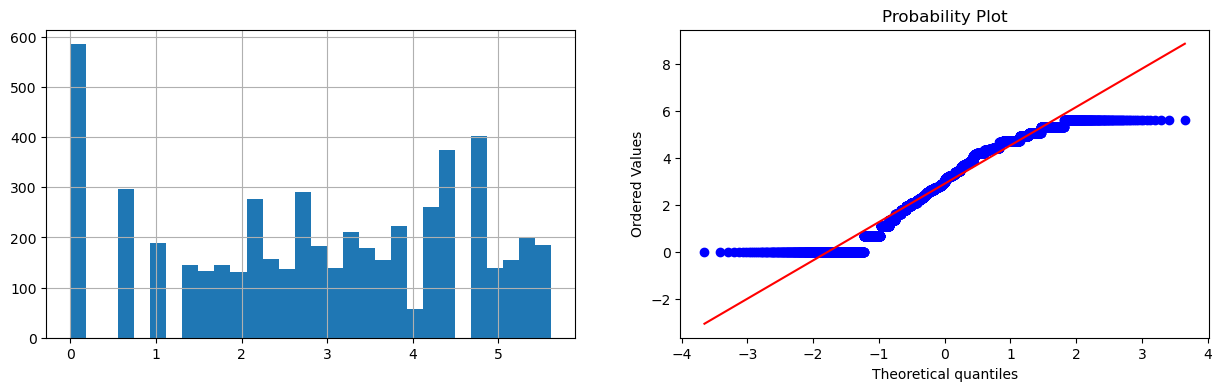

In [114]:
compare_transf(central_df_copy, 'calculated_host_listings_count')

In [115]:
#Numerical Transformation for availability_365

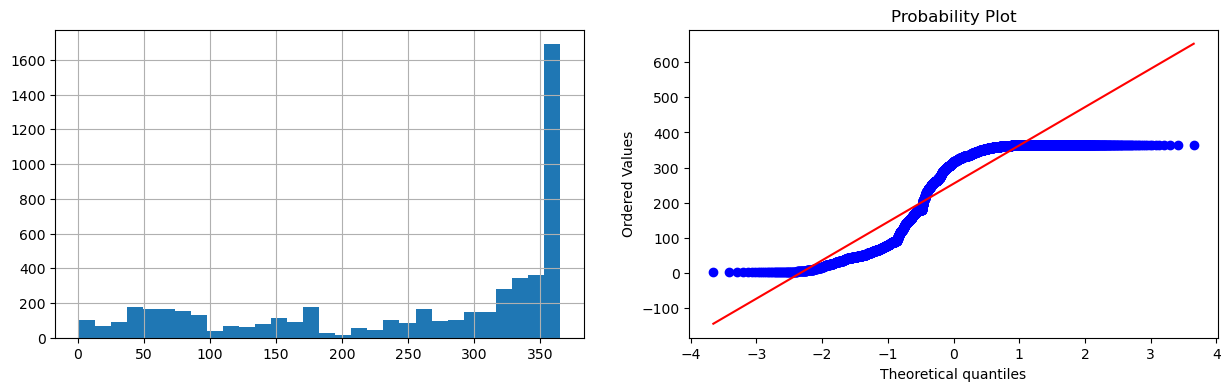

In [116]:
# Original Distribution 
diagnostic_plots_NUM(central_df_copy, 'availability_365')

availability_365_square


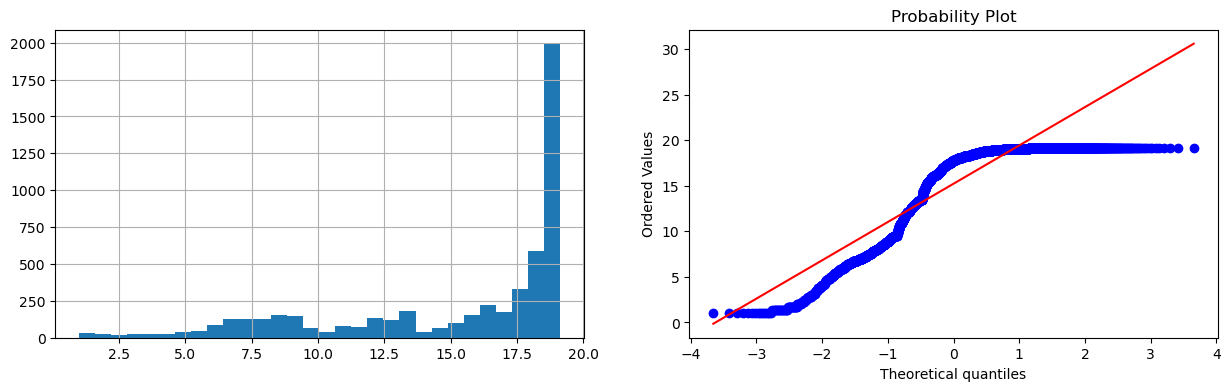

availability_365_cube


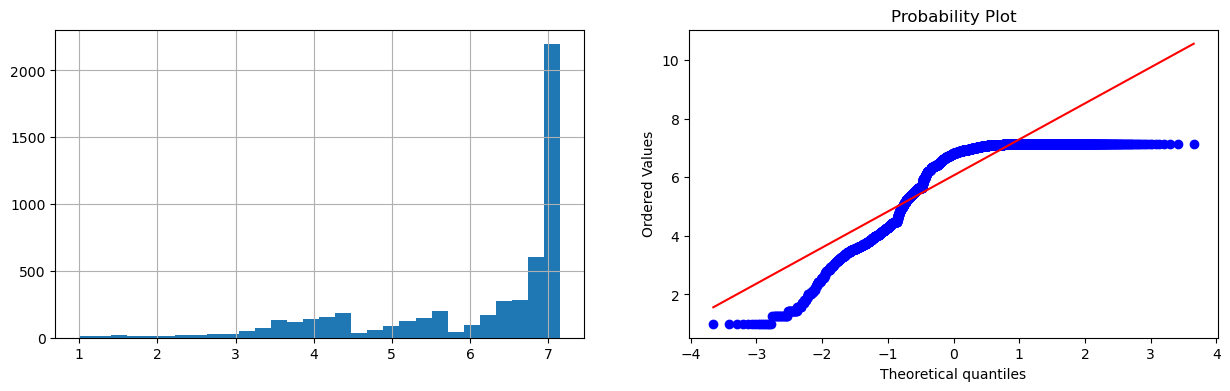

availability_365_rec


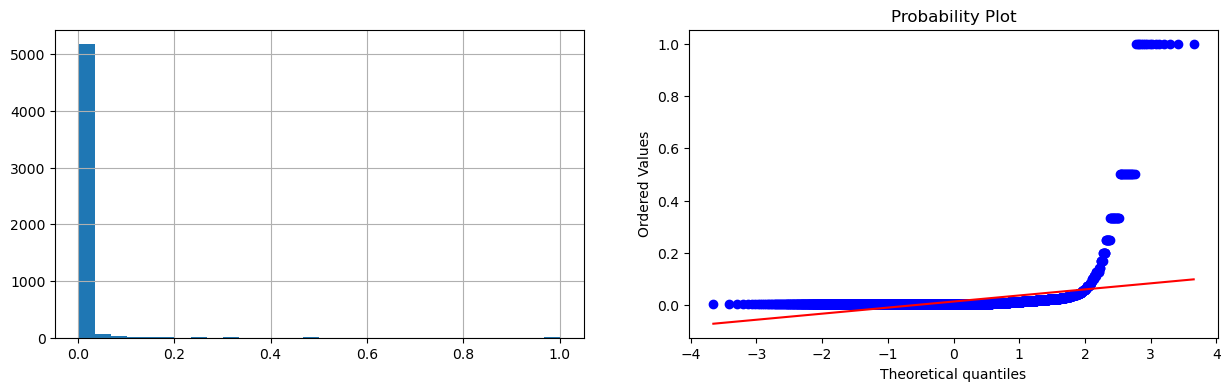

availability_365_log


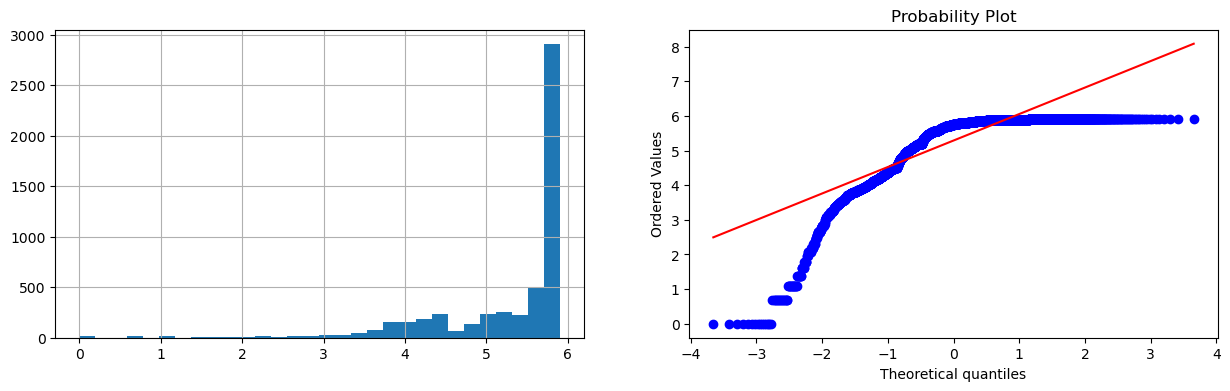

In [117]:
compare_transf(central_df_copy, 'availability_365')

In [118]:
#Apply Transformations

# "calculated_host_listings_count"
Transformer = PowerTransformer(variables = ['number_of_reviews', 'reviews_per_month','calculated_host_listings_count'], exp=1/3)
# fit transformer to data 
Transformer.fit(central_df)
# transform the indicated variables within our data set
central_df = Transformer.transform(central_df)

# "availability_365"
# initialize the transformer
rt = ReciprocalTransformer(variables = ['availability_365'])
# fit transformer to the entire dataframe
rt.fit(central_df)
# transform the indicated variables within our data set
central_df = rt.transform(central_df)

In [119]:
central_df.head()

neighbourhood  latitude  longitude     room_type  price  minimum_nights  \
1    Bukit Timah   1.33235  103.78521  Private room     81              90   
10   Bukit Merah   1.28875  103.80814  Private room     44              15   
11   Bukit Merah   1.28837  103.81099  Private room     40              30   
13        Newton   1.31125  103.83816  Private room     65               2   
14   Bukit Merah   1.28976  103.80896  Private room     44              30   

    number_of_reviews  reviews_per_month  calculated_host_listings_count  \
1            2.620741           0.654213                        1.000000   
10           2.620741           0.612693                        3.174802   
11           2.154435           0.479142                        3.174802   
13           5.000000           1.105209                        1.817121   
14           2.351335           0.531329                        3.174802   

    availability_365  
1           0.002740  
10          0.003021  
11          0.003623  
13          0.002976  
14          0.002941

In [120]:
#Encode Categorical Data

In [121]:
central_df[bnb_cat].nunique()

neighbourhood    19
room_type         3
dtype: int64

In [122]:
#Neighbourhood
# Create an instance of the LabelEncoder class
le = LabelEncoder()

# Fit and transform the neighbourhood column
central_df['neighbourhood'] = le.fit_transform(central_df['neighbourhood'])

# Show the updated DataFrame
central_df.head()

neighbourhood  latitude  longitude     room_type  price  minimum_nights  \
1               2   1.33235  103.78521  Private room     81              90   
10              1   1.28875  103.80814  Private room     44              15   
11              1   1.28837  103.81099  Private room     40              30   
13              8   1.31125  103.83816  Private room     65               2   
14              1   1.28976  103.80896  Private room     44              30   

    number_of_reviews  reviews_per_month  calculated_host_listings_count  \
1            2.620741           0.654213                        1.000000   
10           2.620741           0.612693                        3.174802   
11           2.154435           0.479142                        3.174802   
13           5.000000           1.105209                        1.817121   
14           2.351335           0.531329                        3.174802   

    availability_365  
1           0.002740  
10          0.003021  
11          0.003623  
13          0.002976  
14          0.002941

In [123]:
#Room_Type

# Find the unique values in room_type
unique_values = pd.unique(central_df['room_type'])

# Print the unique values
print(unique_values)

['Private room' 'Entire home/apt' 'Shared room']


In [124]:
room_map = {"Private room": 1, 
            "Entire home/apt": 2,
            "Shared room": 3}

central_df['room_type'] = central_df['room_type'].map(room_map).astype(int)

# Show the updated DataFrame
central_df.head()

neighbourhood  latitude  longitude  room_type  price  minimum_nights  \
1               2   1.33235  103.78521          1     81              90   
10              1   1.28875  103.80814          1     44              15   
11              1   1.28837  103.81099          1     40              30   
13              8   1.31125  103.83816          1     65               2   
14              1   1.28976  103.80896          1     44              30   

    number_of_reviews  reviews_per_month  calculated_host_listings_count  \
1            2.620741           0.654213                        1.000000   
10           2.620741           0.612693                        3.174802   
11           2.154435           0.479142                        3.174802   
13           5.000000           1.105209                        1.817121   
14           2.351335           0.531329                        3.174802   

    availability_365  
1           0.002740  
10          0.003021  
11          0.003623  
13          0.002976  
14          0.002941

In [125]:
#Scaling the data

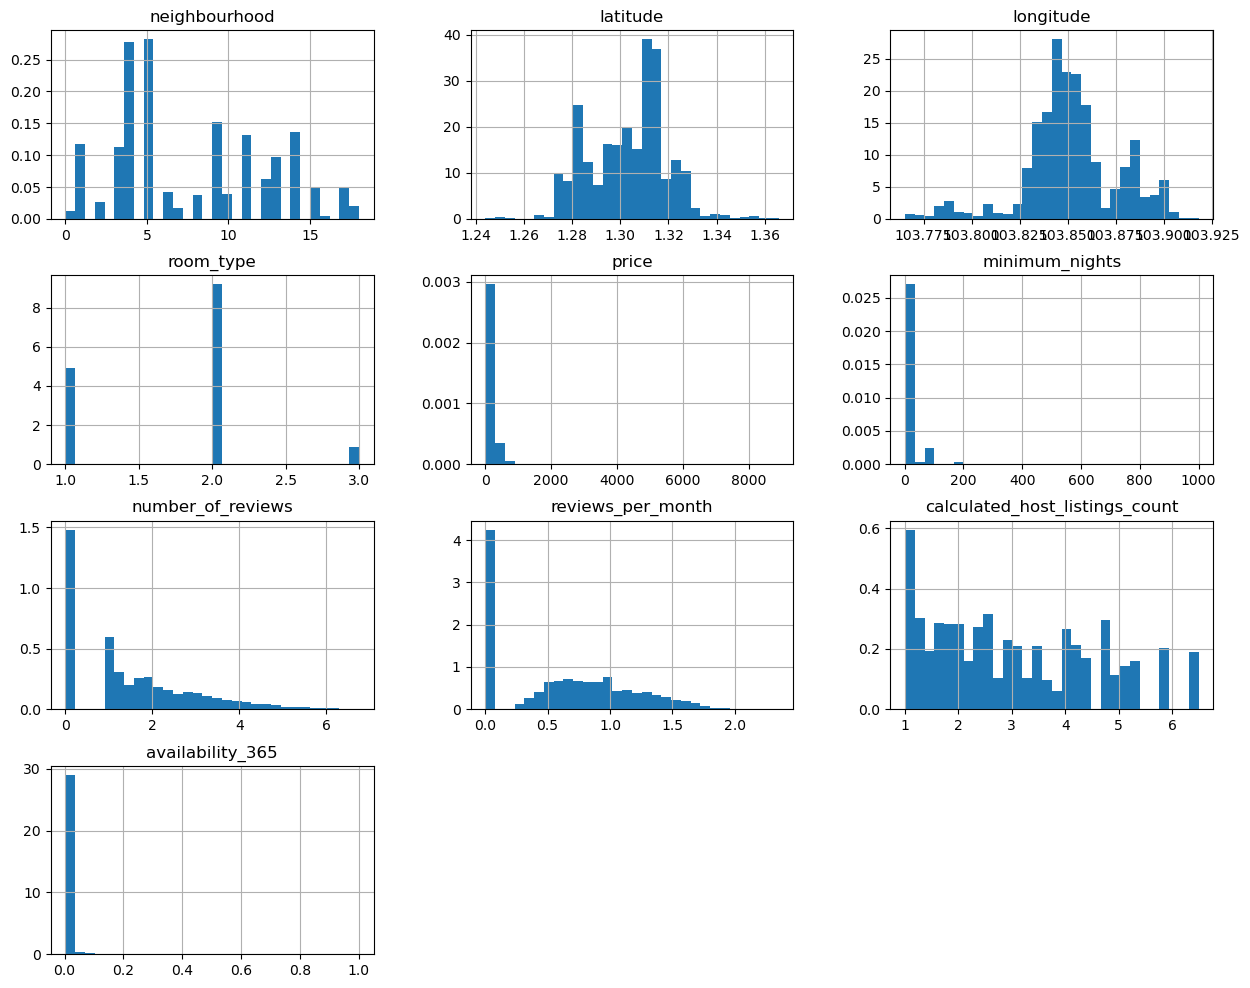

In [126]:
central_df.hist(bins=30, figsize=(15,12), density=True)
plt.show()

In [127]:
# Reset index of central_df
central_df = central_df.reset_index(drop=True)

# Drop target column 'price' from the dataframe
central_df_dropped = central_df.drop(columns=['price'])

In [128]:
#set up the scaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(central_df_dropped)

# transform data sets
central_df_scaled = scaler.transform(central_df_dropped)

# let's transform the returned NumPy arrays to dataframes
central_df_scaled_df = pd.DataFrame(central_df_scaled, columns=central_df_dropped.columns)

In [129]:
#Compare the variable distributions before and after scaling

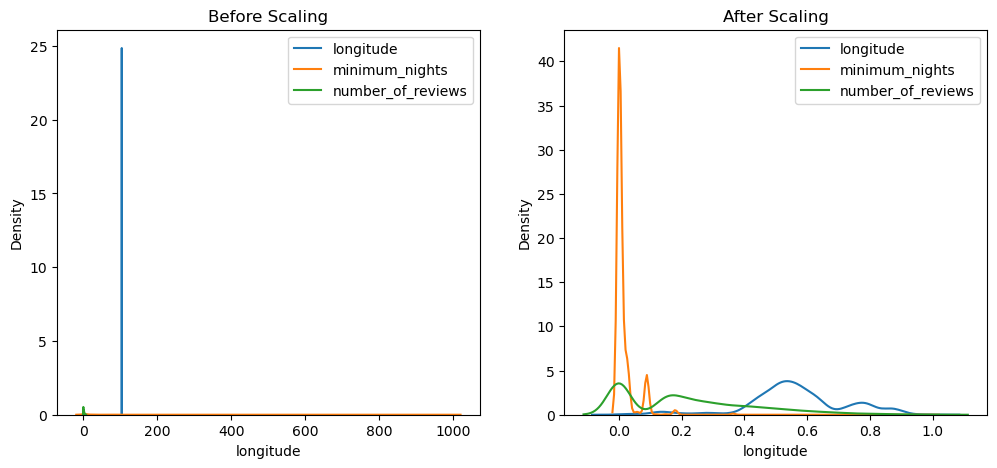

In [130]:
# let's compare the variable distributions before and after scaling

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(central_df['longitude'], ax=ax1, label ='longitude')
sns.kdeplot(central_df['minimum_nights'], ax=ax1, label ='minimum_nights')
sns.kdeplot(central_df['number_of_reviews'], ax=ax1, label ='number_of_reviews')
ax1.legend()

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(central_df_scaled_df['longitude'], ax=ax2, label ='longitude')
sns.kdeplot(central_df_scaled_df['minimum_nights'], ax=ax2, label ='minimum_nights')
sns.kdeplot(central_df_scaled_df['number_of_reviews'], ax=ax2, label ='number_of_reviews')
ax2.legend()
plt.show()

In [131]:
# Add column 'price' back
central_df_scaled_df=central_df_scaled_df.assign(price=central_df['price'])
central_df_scaled_df.head()

neighbourhood  latitude  longitude  room_type  minimum_nights  \
0       0.111111  0.725484   0.130028        0.0        0.089089   
1       0.055556  0.367990   0.280005        0.0        0.014014   
2       0.055556  0.364874   0.298646        0.0        0.029029   
3       0.444444  0.552476   0.476356        0.0        0.001001   
4       0.055556  0.376271   0.285369        0.0        0.029029   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0           0.388488           0.278231                        0.000000   
1           0.388488           0.260572                        0.395774   
2           0.319365           0.203774                        0.395774   
3           0.741180           0.470035                        0.148701   
4           0.348553           0.225969                        0.395774   

   availability_365  price  
0          0.000000     81  
1          0.000282     44  
2          0.000886     40  
3          0.000237     65  
4          0.000202     44

### 2.3 Correlation Analysis

In [132]:
# This shows the correlations between the variables
central_df_scaled_df.corr()

neighbourhood  latitude  longitude  room_type  \
neighbourhood                        1.000000 -0.078305  -0.302419   0.048299   
latitude                            -0.078305  1.000000   0.348658  -0.023221   
longitude                           -0.302419  0.348658   1.000000   0.043932   
room_type                            0.048299 -0.023221   0.043932   1.000000   
minimum_nights                      -0.008401 -0.057089  -0.123290  -0.148688   
number_of_reviews                    0.036718 -0.000233   0.057204  -0.025557   
reviews_per_month                    0.025705 -0.019470   0.053003  -0.012748   
calculated_host_listings_count      -0.072960  0.085462   0.140681   0.202020   
availability_365                     0.004080 -0.031088   0.014900  -0.056164   
price                                0.064179 -0.050197  -0.030930   0.114134   

                                minimum_nights  number_of_reviews  \
neighbourhood                        -0.008401           0.036718   
latitude                             -0.057089          -0.000233   
longitude                            -0.123290           0.057204   
room_type                            -0.148688          -0.025557   
minimum_nights                        1.000000          -0.195170   
number_of_reviews                    -0.195170           1.000000   
reviews_per_month                    -0.240308           0.871486   
calculated_host_listings_count       -0.052629          -0.292480   
availability_365                     -0.044618           0.012393   
price                                -0.078025          -0.090301   

                                reviews_per_month  \
neighbourhood                            0.025705   
latitude                                -0.019470   
longitude                                0.053003   
room_type                               -0.012748   
minimum_nights                          -0.240308   
number_of_reviews                        0.871486   
reviews_per_month                        1.000000   
calculated_host_listings_count          -0.294764   
availability_365                         0.058675   
price                                   -0.069011   

                                calculated_host_listings_count  \
neighbourhood                                        -0.072960   
latitude                                              0.085462   
longitude                                             0.140681   
room_type                                             0.202020   
minimum_nights                                       -0.052629   
number_of_reviews                                    -0.292480   
reviews_per_month                                    -0.294764   
calculated_host_listings_count                        1.000000   
availability_365                                     -0.089293   
price                                                 0.000221   

                                availability_365     price  
neighbourhood                           0.004080  0.064179  
latitude                               -0.031088 -0.050197  
longitude                               0.014900 -0.030930  
room_type                              -0.056164  0.114134  
minimum_nights                         -0.044618 -0.078025  
number_of_reviews                       0.012393 -0.090301  
reviews_per_month                       0.058675 -0.069011  
calculated_host_listings_count         -0.089293  0.000221  
availability_365                        1.000000 -0.027006  
price                                  -0.027006  1.000000

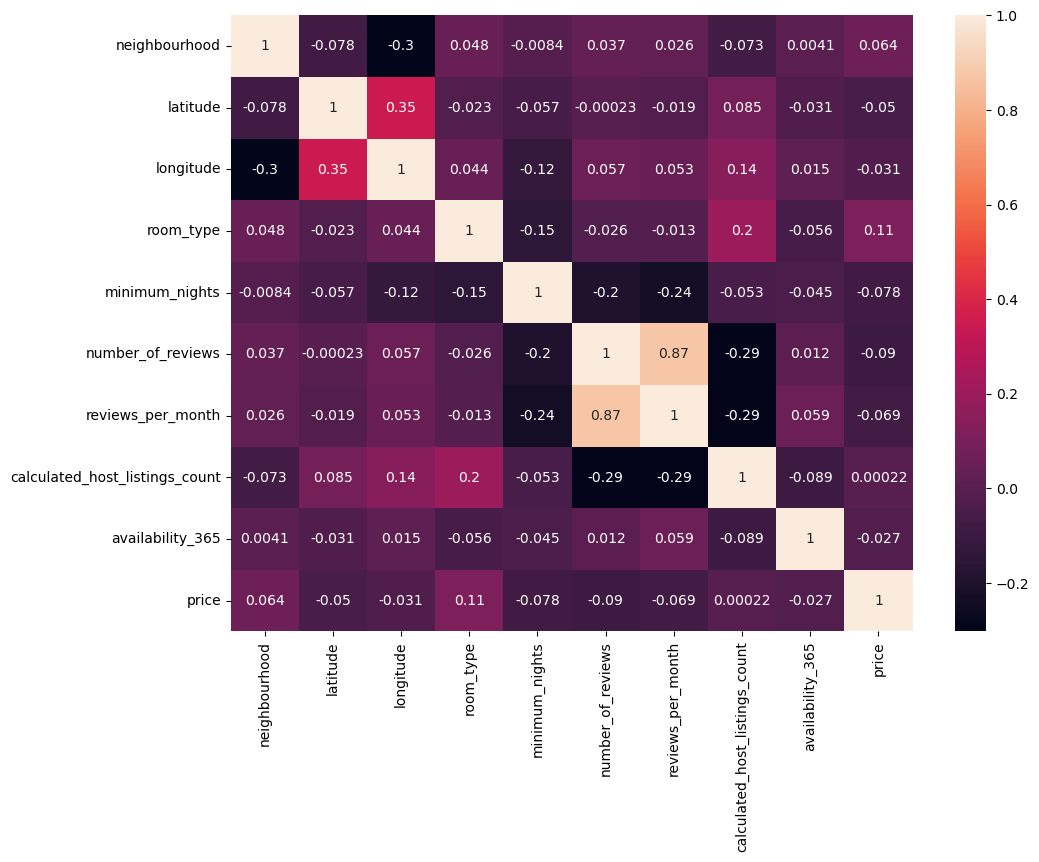

In [133]:
# Heatmap: the correlation between any two features/variables
plt.figure(figsize=(11,8))
sns.heatmap(central_df_scaled_df.corr(),annot=True)
plt.show()

In [134]:
central_df_scaled_df.drop(columns=['calculated_host_listings_count'], inplace=True)

# Rename dataframe
final_df = central_df_scaled_df

final_df.head()

neighbourhood  latitude  longitude  room_type  minimum_nights  \
0       0.111111  0.725484   0.130028        0.0        0.089089   
1       0.055556  0.367990   0.280005        0.0        0.014014   
2       0.055556  0.364874   0.298646        0.0        0.029029   
3       0.444444  0.552476   0.476356        0.0        0.001001   
4       0.055556  0.376271   0.285369        0.0        0.029029   

   number_of_reviews  reviews_per_month  availability_365  price  
0           0.388488           0.278231          0.000000     81  
1           0.388488           0.260572          0.000282     44  
2           0.319365           0.203774          0.000886     40  
3           0.741180           0.470035          0.000237     65  
4           0.348553           0.225969          0.000202     44

In [135]:
print('Before filtering, cleaning and transformation:', df_bnb.shape, 
      '\nAfter filtering, cleaning and transformation:', final_df.shape)

Before filtering, cleaning and transformation: (7907, 16) 
After filtering, cleaning and transformation: (5354, 9)


### 2.4 Export the data

In [136]:
final_df.to_csv('listings_new.csv', index=False)